# Stacked Machine Learning

In [2]:
## IMPORTANT !

# In the first order need to set the number of CPU 
# for calculation before launching (depends on computer's number of cores)
n_jobs= 110

### Load libraries

In [3]:
#libraries
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import pearsonr
import os
import sys
import shutil
import glob

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime
import warnings

import matplotlib.axis as axis

from sklearn.utils import resample
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
import scipy.stats as st

from nilearn import image as nli
from nilearn import plotting
from PIL import Image

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

from mne.viz import plot_connectivity_circle

### Load functions

In [4]:
def control_2(z, control, index):    #age+gender == 2
    #z should be a series
    #control is a feature table
    #index for indexing
    
    #shrink data to local train index
    y = z.reindex(index = index)
    X = control.reindex(index = index)

    #drop Nan in target and clean this subj from features
    y = y.dropna()
    X = X.loc[y.index,:]
    ind_y = np.array(y.index)
    
    #Centralize target by y_i-y_mean
    y= pd.DataFrame([i-y.mean() for i in y], index=y.index)    
    #y_real = y
    
    #reshaping data
    X = X.values
    y = y.values.reshape(-1, 1).ravel()
    
    #fill Nan in X
    X = SimpleImputer(strategy='mean').fit_transform(X)
    
    #Standartize X
    X = StandardScaler().fit_transform(X)
    
    #Fit to the training set
    y_pred = LinearRegression().fit(X, y).predict(X)
    
    y_res = y - y_pred
    
    return y_res, ind_y

In [5]:
def control_mov_feature(z, control, mov, index): #age+gender+each specific task movement == 3
    #z should be a table of features
    #mov should be a series with movements for a specific modality
    
    #shrink data to local train index
    z = z.reindex(index = index)
    control = control.reindex(index = index)
    mov = mov.reindex(index = index) 
    ind = z.index
    #concal control with mov
    cont = control
    cont['mov'] = mov
    
    #loop
    dct = {}
    col_name = z.columns
    for col in col_name:
        y = z[col]
        X = cont
        
        #Centralize target by y_i-y_mean
        y= pd.DataFrame([i-y.mean() for i in y], index=y.index) 
        
        #reshaping data
        X = X.values
        y = y.values.reshape(-1, 1).ravel()

        #fill Nan in X
        X = SimpleImputer(strategy='mean').fit_transform(X)

        #Standartize X
        X = StandardScaler().fit_transform(X)

        #Fit to the training set
        y_pred = LinearRegression().fit(X, y).predict(X)

        y_res = y - y_pred
        
        dct[col] = y_res
    
    df_t = pd.DataFrame(dct, index = ind)
    
    return df_t

In [6]:
def elnet(X, y):

    #drop Nan in target and clean this subj from features
    y = y.dropna()
    X = X.loc[y.index,:]
    ind_y = np.array(y.index)
      
    y_real=y
    
    #reshaping data
    X = X.values
    y = y.values.reshape(-1, 1).ravel()
    
    #fill Nan in X
    X = SimpleImputer(strategy='mean').fit_transform(X)
    
    #Standartize X
    X = StandardScaler().fit_transform(X)
    
    # Setup the pipeline steps:
    steps = [('elasticnet', ElasticNet(random_state=42))]

    # Create the pipeline: pipeline 
    pipeline = Pipeline(steps)

    # Specify the hyperparameter space
    parameters = {'elasticnet__alpha': np.logspace(-6, 4, 500),
                  'elasticnet__l1_ratio':np.linspace(0,1,100)}

    # Create the GridSearchCV object:
    gm_cv = GridSearchCV(pipeline, parameters, cv=5, n_jobs=n_jobs)
    
    # Fit to the training set
    gm_cv.fit(X, y)
    
    #predict new y
    y_pred = gm_cv.predict(X)

    # Compute and print the metrics
    acc = gm_cv.best_score_
    bpar = gm_cv.best_params_
    model = gm_cv.best_estimator_
    mse = mean_squared_error(y_real, y_pred)
    mae = mean_absolute_error(y_real, y_pred)
    corr, _ = pearsonr(np.array(y_real.values.reshape(-1, 1).ravel(), dtype=float), np.array(y_pred, dtype=float))
            
    return bpar['elasticnet__alpha'], bpar['elasticnet__l1_ratio'], acc, mse, corr, model, y_pred, mae

In [7]:
def reaply_ElNet(X, y, model):
    # param should be pd.Series with indexes from model
    
    #drop Nan in target and clean this subj from features
    y = y.dropna()
    X = X.reindex(index =y.index)
    ind_y = np.array(y.index)  # indexes as separate variable 
    
    y_real = y

    #reshaping data
    X = X.values
    y = y.values.reshape(-1, 1).ravel()
    
    #fill Nan in X
    X = SimpleImputer(strategy='mean').fit_transform(X)
    
    #Standartize X
    X = StandardScaler().fit_transform(X)
    
    #predict new y
    y_pred = model.predict(X)
    
    # Compute and print the metrics
    bacc = model.score(X, y)
    mse = mean_squared_error(y_real, y_pred)
    mae = mean_absolute_error(y_real, y_pred) 
    corr, _ = pearsonr(np.array(y_real.values.reshape(-1, 1).ravel(), dtype=float), np.array(y_pred, dtype=float))
    
    return y_pred, y_real, ind_y, bacc, mse, corr, mae

### Path to the tables folder

In [32]:
path='/media/DataD800/Alina/MLtables/'

### Load tables

In [33]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

#demography
demo = pd.read_csv(path+'demographics_table.csv', index_col=0)

#targets table
targ = pd.read_csv(path+'cognition_table.csv', index_col=0)

#features tables as dictionary
features = {
    'emo':pd.read_csv(path+'emo_table.csv', index_col=0),
    'gam':pd.read_csv(path+'gam_table.csv', index_col=0),
    'lan':pd.read_csv(path+'lan_table.csv', index_col=0),
    'mot':pd.read_csv(path+'mot_table.csv', index_col=0),
    'rel':pd.read_csv(path+'rel_table.csv', index_col=0),
    'soc':pd.read_csv(path+'soc_table.csv', index_col=0),
    'wm':pd.read_csv(path+'wm_table.csv', index_col=0),
    'cort':pd.read_csv(path+'cort_table.csv', index_col=0),
    'subc':pd.read_csv(path+'subc_table.csv', index_col=0),
    'surf':pd.read_csv(path+'surf_table.csv', index_col=0),
    'rest':pd.read_csv(path+'rest_table_featfiltered.csv', index_col=0),
    'VolBrain':pd.read_csv(path+'VolBrain_table.csv', index_col=0)
}


#table with movements (mean relative displacement Movement_RelativeRMS_mean.txt)
movements = pd.read_csv(path+'movement_table.csv', index_col=0)

#create tables with 2 controling parameters: gender and age
age_coded = pd.Series(LabelEncoder().fit_transform(demo.loc[:,['Gender']]), index=demo.index, name='Gender')
control = pd.concat([age_coded, demo.loc[:, ['Age_in_Yrs']]], axis=1)

##### Leave-51-group out based on 8-Fold CV

In [9]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
####################################################
# BE CAREFUL!!!
####################################################
#launching this part you can erase previous ML results, if the output folder was not renamed manually

#for col in targ.columns:
col = 'CogTotalComp_Unadj'  #the script adapted to be launched on table of target variables. To launch in that way you need to uncomment for loop and comment this row with col variable
y = targ[col]

print(y.name)

group_kfold = GroupKFold(n_splits=8)

#this part checking for the output folder existence, and do: 1) or erase it if name exist, 2) or create it
if os.path.exists(path+'output_'+str(y.name)):
    # removing the dir totally
    shutil.rmtree(path+'output_'+str(y.name))
    #create directory for specific y
    os.mkdir(path+'output_'+str(y.name))
else:
    #create directory for specific y
    os.mkdir(path+'output_'+str(y.name)) # the name for the output folder is the column name for target table


i=0

for train_index, test_index in group_kfold.split(demo, groups=demo['Family_ID']): 

    print(' ')
    print('started to calculate the Fold #', i)
    print(datetime.now())
    print(' ')

    #create directory for specific Fold
    os.mkdir(path+'output_'+str(y.name)+'/Fold_'+str(i)) 
    path_out = str(path+'output_'+str(y.name)+'/Fold_'+str(i))

    #Global indices
    train_index = np.array(demo.iloc[train_index].index, dtype='int') #for training all models
    test_index = np.array(demo.iloc[test_index].index, dtype='int') #for final test
    
    #Split global train_Gindex to local indices
    index_train, index_test = train_test_split(train_index, test_size=0.4, random_state=42)

    #Local indices
    index_train = np.array(sorted(index_train), dtype='int') #for training modalities models
    index_test = np.array(sorted(index_test), dtype='int') #for testing modalities and training RF


    ### 1st level ################################################################################

    #### Calculations of single ML models on index_train #################################### 

    print('start 1st level ', datetime.now())

    #control for age+gen and age+gen+mov with sorting to index_train

    #control y (target) for age+gen
    p1, p2 = control_2(y, control, index_train) #where p1 = y_res (residuals), p2 = ind_y (index)
    y_res1 = pd.Series(p1, index = p2)

    #control modalities
    features_res1 = {}
    for key in features.keys():

        #controlling tasks for 3 parameter (age+gen+mov)
        if key in ['emo', 'gam', 'lan', 'mot', 'rel', 'soc', 'wm', 'rest']:
            features_res1[key] = control_mov_feature(features[key], control, movements[key], index_train)

        #controlling the remaining for 2 parameters (age+gen)
        if key in ['cort', 'surf', 'subc', 'VolBrain']:
            d = {}
            for col in features[key].columns:
                p1,p2 = control_2(features[key][col], control, index_train)
                d[col] = p1
            df= pd.DataFrame(d, index = p2)
            features_res1[key] = df


    #Launch ElasticNet for all task(modalities) on index_train (1st level)

    dict_tasks={}
    dict_elnet_model={}
    dict_ypred1={}

    for key in list(features_res1.keys()):

        print('start ', str(key), datetime.now())   #print start time of calculations

        bpar1, bpar2, acc, mse, corr, model, y_pred1, mae = elnet(features_res1[key], y_res1) #ML
        dict_tasks[key] = acc, mse, mae, corr, bpar1, bpar2 
        dict_elnet_model[key] = model
        dict_ypred1[key] = y_pred1
    df_tasks = pd.DataFrame(dict_tasks, index=['best score r2', 'mse', 'mae','corr', 'best alpha', 'best l1_ratio'])
    df_y_pred1 = pd.DataFrame(dict_ypred1, index=y_res1.index)


    ###Save outputs from this step (models and all mod. perf.)

    #model
    for key in dict_elnet_model.keys():
        joblib.dump(dict_elnet_model[key], (path_out+'/'+str(key)+'_elnet_model.sav'))

    #model performance
    df_tasks.to_csv(path_out+'/1level_train_perf_elnet.csv')

    #list of first level targets (observed and predicted)
    y_res1.to_csv(path_out+'/1level_train_y_real_residual_index.csv', header=None)
    df_y_pred1.to_csv(path_out+'/1level_train_y_pred_singleML.csv')
    
    
    
    ### 2st level ################################################################################
    print(' ')
    print('start 2nd level ', datetime.now())
    
    #### L2 Testing single ML models on index_test #############################################
    
    print('Checking single ML on test1 data ', datetime.now())

    #control for age+gen and age+gen+mov with sorting to index_test

    #control y (target) for age+gen
    p1, p2 = control_2(y, control, index_test)
    y_res2 = pd.Series(p1, index = p2)

    #control modalities
    features_res2 = {}
    for key in features.keys():

        #controlling tasks for 3 parameter (age+gen+mov)
        if key in ['emo', 'gam', 'lan', 'mot', 'rel', 'soc', 'wm', 'rest']:
            features_res2[key] = control_mov_feature(features[key], control, movements[key], index_test)

        #controlling the remaining for 2 parameters (age+gen)
        if key in ['cort', 'surf', 'subc', 'VolBrain']:
            d = {}
            for col in features[key].columns:
                p1,p2 = control_2(features[key][col], control, index_test)
                d[col] = p1
            df= pd.DataFrame(d, index = p2)
            features_res2[key] = df        


    #apply trained single models ElasticNet to new data , index_test

    dict_y_pred2={}
    dict_y_pred2_per={}
    for key in list(features_res2.keys()):
        y_pred, y_real, ind_y, bacc, mse, corr, mae = reaply_ElNet(features_res2[key], y_res2, dict_elnet_model[key]) #ML
        dict_y_pred2[key] = y_pred
        dict_y_pred2_per[key] = bacc, mse, mae, corr

    df_y_pred2 = pd.DataFrame(dict_y_pred2, index=ind_y)
    df_y_pred2_per = pd.DataFrame(dict_y_pred2_per, index=['best score r2', 'mse', 'mae','corr'])


    ###Save outputs from this step (models and all mod. perf.)

    #model performance
    df_y_pred2_per.to_csv(path_out+'/2level_test1_perf_elnet.csv')

    #list of first level targets (observed and predicted)
    y_res2.to_csv(path_out+'/2level_test1_y_real_residual_index.csv', header=None)
    df_y_pred2.to_csv(path_out+'/2level_test1_y_pred_singleML.csv')   
    
    
    
    #### L2 Calculating stacked ML models on index_test #############################################
    
    print('Calculating stacked ML on test1 data ', datetime.now())    


    #identifying sets for several stacked models
    set2 = ['emo', 'gam', 'lan', 'mot', 'rel', 'soc', 'wm']
    set3 = ['cort', 'subc', 'surf', 'rest', 'VolBrain']
    set1 = list(df_y_pred2.columns) #all existed modalities

    #for presetet sets
    dict_st_perf1={}
    dict_st_models={}
    dict_st_ypred1={}

    s=1
    for set_n in [set1, set2, set3]:
        print('set '+str(s), datetime.now())
        
        st_features = df_y_pred2.loc[:,set_n]

        bpar1, bpar2, acc, mse, corr, model, y_pred3, mae = elnet(st_features, y_res2) #ML

        dict_st_perf1['set'+str(s)] = acc, mse, mae, corr, bpar1, bpar2 
        dict_st_models['set'+str(s)] = model
        dict_st_ypred1['set'+str(s)] = y_pred3
        s+=1

    df_st_perf1 = pd.DataFrame(dict_st_perf1, index=['best score r2', 'mse', 'mae','corr', 'best alpha', 'best l1_ratio'])
    df_st_ypred1 = pd.DataFrame(dict_st_ypred1, index=y_res2.index)        

    ###Save outputs from this step (models and all mod. perf.)

    #models
    for key in dict_st_models.keys():
        joblib.dump(dict_st_models[key], (path_out+'/'+str(key)+'_stacked_model.sav'))

    #performance and prediction
    df_st_perf1.to_csv(path_out+'/2level_test1_perf_stacked.csv')
    df_st_ypred1.to_csv(path_out+'/2level_test1_y_pred_stacked.csv')
    
    
    
    ### 3rd level ################################################################################
    print(' ')
    print('start 3rd level ', datetime.now())
    
    
    #### L3 Testing single ML models on test_index #############################################

    print('Checking single ML on test2 data ', datetime.now())

    #control for age+gen and age+gen+mov with sorting to index_test

    #control y (target) for age+gen
    p1, p2 = control_2(y, control, test_index)
    y_res3 = pd.Series(p1, index = p2)

    #control modalities
    features_res3 = {}
    for key in features.keys():

        #controlling tasks for 3 parameter (age+gen+mov)
        if key in ['emo', 'gam', 'lan', 'mot', 'rel', 'soc', 'wm', 'rest']:
            features_res3[key] = control_mov_feature(features[key], control, movements[key], test_index)

        #controlling the remaining for 2 parameters (age+gen)
        if key in ['cort', 'surf', 'subc', 'VolBrain']:
            d = {}
            for col in features[key].columns:
                p1,p2 = control_2(features[key][col], control, test_index)
                d[col] = p1
            df= pd.DataFrame(d, index = p2)
            features_res3[key] = df        


    #apply trained single models ElasticNet to new data , test_index

    dict_y_pred3={}
    dict_y_pred3_per={}
    for key in list(features_res3.keys()):
        y_pred, y_real, ind_y, bacc, mse, corr, mae = reaply_ElNet(features_res3[key], y_res3, dict_elnet_model[key]) #ML
        dict_y_pred3[key] = y_pred
        dict_y_pred3_per[key] = bacc, mse, mae, corr

    df_y_pred3 = pd.DataFrame(dict_y_pred3, index=ind_y)
    df_y_pred3_per = pd.DataFrame(dict_y_pred3_per, index=['best score r2', 'mse', 'mae','corr'])


    ###Save outputs from this step (models and all mod. perf.)

    #model performance
    df_y_pred3_per.to_csv(path_out+'/3level_test2_perf_elnet.csv')

    #list of first level targets (observed and predicted)
    y_res3.to_csv(path_out+'/3level_test2_y_real_residual_index.csv', header=None)
    df_y_pred3.to_csv(path_out+'/3level_test2_y_pred_singleML.csv')        

    
    #### L3 Testing stacked ML models on test_index #############################################
    
    print('Calculating stacked ML on test2 data ', datetime.now()) 
    
    #apply trained stacked models ElasticNet to new data , test_index

    #for presetet sets
    dict_st_perf2={}
    dict_st_ypred2={}
    s=1
    for set_n in [set1, set2, set3]:
        ftrs = df_y_pred3.loc[:, set_n]
        y_pred, y_real, ind_y, bacc, mse, corr, mae = reaply_ElNet(ftrs, y_res3, dict_st_models[('set'+str(s))]) #ML
        dict_st_ypred2[('set'+str(s))] = y_pred
        dict_st_perf2[('set'+str(s))] = bacc, mse, mae, corr
        s+=1

    df_st_ypred2 = pd.DataFrame(dict_st_ypred2, index=ind_y)
    df_st_perf2 = pd.DataFrame(dict_st_perf2, index=['best score r2', 'mse', 'mae','corr'])        

    ###Save outputs from this step (models and all mod. perf.)

    #performance and prediction
    df_st_perf2.to_csv(path_out+'/3level_test2_perf_stacked.csv')
    df_st_ypred2.to_csv(path_out+'/3level_test2_y_pred_stacked.csv') 
    
    
    print(' ')
    print('finished to calculate the Fold #', i)
    print(datetime.now())

    i+=1



CogTotalComp_Unadj
 
started to calculate the Fold # 0
2021-08-01 20:04:39.472669
 
start 1st level  2021-08-01 20:04:39.475061
start  emo 2021-08-01 20:05:38.378557
start  gam 2021-08-01 20:14:49.113888
start  lan 2021-08-01 20:21:43.477125
start  mot 2021-08-01 20:28:37.372912
start  rel 2021-08-01 20:35:34.951219
start  soc 2021-08-01 20:42:31.456035
start  wm 2021-08-01 20:49:26.484042
start  cort 2021-08-01 20:56:18.504483
start  subc 2021-08-01 21:01:39.008409
start  surf 2021-08-01 21:06:37.698584
start  rest 2021-08-01 21:11:58.966805
start  VolBrain 2021-08-02 01:22:08.812304
 
start 2nd level  2021-08-02 01:28:03.455072
Checking single ML on test1 data  2021-08-02 01:28:03.455587
Calculating stacked ML on test1 data  2021-08-02 01:28:42.595907
set 1 2021-08-02 01:28:42.595998
set 2 2021-08-02 01:34:06.231475
set 3 2021-08-02 01:39:26.146210
 
start 3rd level  2021-08-02 01:44:47.126288
Checking single ML on test2 data  2021-08-02 01:44:47.126334
Calculating stacked ML on test

Calculating stacked ML on test1 data  2021-08-03 17:50:49.952026
set 1 2021-08-03 17:50:49.952325
set 2 2021-08-03 17:56:13.711417
set 3 2021-08-03 18:01:37.113368
 
start 3rd level  2021-08-03 18:06:57.490198
Checking single ML on test2 data  2021-08-03 18:06:57.490247
Calculating stacked ML on test2 data  2021-08-03 18:07:13.902663
 
finished to calculate the Fold # 7
2021-08-03 18:07:13.913046


### CV stats

In [8]:
#creating new path variable
#path2 = path_out[:-6]
path2 = '/media/DataD800/Alina/MLtables/output_CogTotalComp_Unadj_1/'
folders = sorted((os.listdir(path2)))[:8]
print(path2)
print(folders)

/media/DataD800/Alina/MLtables/output_CogTotalComp_Unadj_1/
['Fold_0', 'Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5', 'Fold_6', 'Fold_7']


In [9]:
#full label
lblY = ['Emotional Task',
'Gambling Task',
'Language Task',
'Motor Task', 
'Relational Task',
'Social Task', 
'Working Memory Task',
'Cortical Thickness',
'Subcortical Volume',
'Surface Area', 
'Resting-State FC', 
'Total Brain Volume',
'All-Modality Stacked Model',
'Task Stacked Model', 
'Non-Task Stacked Model']

In [10]:
#assamble y_pred from all folds into one table
#open dict for storing results
dt_ypred_all = {}
#launch a loop for assembling
for fold in folders:
    #read saved tables
    df1 = pd.read_csv(path2+fold+'/3level_test2_y_pred_singleML.csv', index_col=0)
    df2 = pd.read_csv(path2+fold+'/3level_test2_y_pred_stacked.csv', index_col=0)
    yrl = pd.read_csv(path2+fold+'/3level_test2_y_real_residual_index.csv', index_col=0,header=None, squeeze=True)
    yrl.index.name = None
    #concat all in one for one fold
    df_y_rp = pd.concat([df1,df2], axis=1)
    df_y_rp['y_real'] = yrl
    df_y_rp['fold'] = np.full(len(yrl), fold[-1], dtype=int)
    #write to dict
    dt_ypred_all[fold] = df_y_rp
    
#transform dict to one table
df_y_all = dt_ypred_all[folders[0]]
for fold in folders[1:]:
    df_y_all = pd.concat([df_y_all, dt_ypred_all[fold]], axis=0)
#save
df_y_all.to_csv(path2+'all_fold_y-pred_y-obs.csv')

In [11]:
#assamble performance indexes into separete tables and save
#open dict for storing fold's results
dt_r2 = {}
dt_mse = {}
dt_mae = {}
dt_cor = {}
#launch a loop for assembling
for fold in folders:
    #read saved tables
    df1 = pd.read_csv(path2+fold+'/3level_test2_perf_elnet.csv', index_col=0) 
    df2 = pd.read_csv(path2+fold+'/3level_test2_perf_stacked.csv', index_col=0)
    df_p = pd.concat([df1, df2], axis=1)
    #assign to dict
    dt_r2[fold] = df_p.iloc[0,:]
    dt_mse[fold] = df_p.iloc[1,:]
    dt_mae[fold] = df_p.iloc[2,:]
    dt_cor[fold] = df_p.iloc[3,:]
#transfrom dict to tables
df_r2 = pd.DataFrame(dt_r2).T
df_mse = pd.DataFrame(dt_mse).T
df_mae = pd.DataFrame(dt_mae).T
df_cor = pd.DataFrame(dt_cor).T
#and save these tables
df_r2.to_csv(path2+'r2_all_fold_cv_perf.csv')
df_mse.to_csv(path2+'mse_all_fold_cv_perf.csv')
df_mae.to_csv(path2+'mae_all_fold_cv_perf.csv')
df_cor.to_csv(path2+'cor_all_fold_cv_perf.csv')

In [110]:
#creating table of mean cv performance
df_mper = pd.DataFrame({'r2' : df_r2.mean(),
                       'mse' : df_mse.mean(),
                       'mae' : df_mae.mean(),
                       'cor' : df_cor.mean()})
df_mper.index = lblY
#save it
#df_mper.to_csv(path2+'mean_cv_perf.csv')
#display sorting by r2
print('Mean CV Performance')
display(df_mper.sort_values(by='r2', ascending=False))

Mean CV Performance


r2         mse        mae       cor
All-Modality Stacked Model  0.334993  128.620646   9.079060  0.581792
Task Stacked Model          0.292537  136.988912   9.407758  0.543803
Working Memory Task         0.211591  153.090065  10.101360  0.460960
Language Task               0.166369  160.940566  10.193513  0.415311
Non-Task Stacked Model      0.128717  168.359561  10.566969  0.367405
Resting-State FC            0.115321  171.215977  10.672774  0.347400
Relational Task             0.114428  171.641601  10.596531  0.339169
Motor Task                  0.063377  181.732330  11.019767  0.265061
Emotional Task              0.062893  181.837650  11.055979  0.252662
Social Task                 0.058337  182.496097  10.969464  0.250135
Surface Area                0.051281  183.977715  11.096923  0.235133
Total Brain Volume          0.038613  186.640369  11.125497  0.200332
Subcortical Volume          0.023846  189.172992  11.249998  0.182813
Cortical Thickness          0.001705  193.664419  11.362810  0.097089
Gambling Task               0.000000  194.067260  11.373821       NaN

In [111]:
#creating table of std cv performance
df_stper = pd.DataFrame({'r2' : df_r2.std(),
                       'mse' : df_mse.std(),
                       'mae' : df_mae.std(),
                       'cor' : df_cor.std()})
df_stper.index = lblY
#save it
#df_mper.to_csv(path2+'mean_cv_perf.csv')
#display sorting by r2
print('StD of CV Performance')
display(df_stper.loc[(df_mper.sort_values(by='r2', ascending=False)).index, :])

StD of CV Performance


r2        mse       mae       cor
All-Modality Stacked Model  0.047633   9.208262  0.443760  0.044690
Task Stacked Model          0.053701  12.739678  0.506960  0.051549
Working Memory Task         0.034154  16.184078  0.631926  0.039312
Language Task               0.076955  11.462549  0.507178  0.112004
Non-Task Stacked Model      0.084751  14.492062  0.355968  0.117984
Resting-State FC            0.059120  13.327284  0.418642  0.093452
Relational Task             0.049364  15.879209  0.597882  0.079687
Motor Task                  0.045703  17.966041  0.657062  0.113435
Emotional Task              0.054732  19.045174  0.723776  0.105714
Social Task                 0.039433  14.785052  0.547969  0.090650
Surface Area                0.048026  18.071948  0.625242  0.093562
Total Brain Volume          0.039223  19.590743  0.644977  0.107111
Subcortical Volume          0.033285  14.785463  0.553068  0.136355
Cortical Thickness          0.050232  18.919746  0.656746  0.152869
Gambling Task               0.000000  17.456396  0.626527       NaN

##### All folds models parameters

In [14]:
dct_param_alpha = {}
dct_param_lratio = {}
for fold in folders:
    df1 = pd.read_csv(path2+fold+'/1level_train_perf_elnet.csv', index_col=0)
    df2 = pd.read_csv(path2+fold+'/2level_test1_perf_stacked.csv', index_col=0)
    dct_param_alpha[fold] = pd.concat([df1.iloc[4,:], df2.iloc[4,:]], axis=0)
    dct_param_lratio[fold] = pd.concat([df1.iloc[5,:], df2.iloc[5,:]], axis=0)
df_param_alpha = pd.DataFrame(dct_param_alpha).T
df_param_lratio = pd.DataFrame(dct_param_lratio).T
print('all best ALPHA parameters')
display(df_param_alpha)
print('all best L_RATIO parameters')
display(df_param_lratio)

df_param_alpha.to_csv(path2+'best_param_alpha_all.csv')
df_param_lratio.to_csv(path2+'best_param_lratio_all.csv')

all best ALPHA parameters


emo       gam       lan       mot       rel       soc        wm  \
Fold_0  3.742366  2.709354  1.873032  2.709354  2.709354  1.180713  2.709354   
Fold_1  1.127468  2.359095  1.076624  4.713535  0.895166  4.713535  0.981712   
Fold_2  3.573602  2.587174  0.981712  4.104181  3.412449  3.919100  1.076624   
Fold_3  5.413360  2.359095  0.937441  1.961486  4.104181  2.837304  1.873032   
Fold_4  1.961486  2.359095  2.252711  1.630891  7.140151  2.837304  2.252711   
Fold_5  4.298001  1.961486  2.837304  5.169242  3.919100  2.837304  1.180713   
Fold_6  5.169242  2.054117  3.111616  2.587174  1.557345  1.487115  3.111616   
Fold_7  4.104181  2.587174  3.412449  6.818162  3.742366  2.359095  1.420053   

            cort      subc      surf       rest  VolBrain      set1      set2  \
Fold_0  1.180713  0.779442  2.587174  65.408059  0.538844  0.427821  0.372514   
Fold_1  2.151123  0.816251  0.816251   1.236472  0.710728  0.408529  0.648072   
Fold_2  3.742366  1.236472  1.707910   1.788566  0.186441  0.390106  0.269688   
Fold_3  1.630891  1.180713  1.028073   3.742366  0.491341  0.448025  0.309729   
Fold_4  2.359095  0.981712  1.873032   5.669007  0.514544  0.538844  0.214122   
Fold_5  1.236472  1.180713  1.420053  34.282315  0.123078  0.295762  0.195246   
Fold_6  1.294865  0.564291  3.573602  16.384336  0.008088  0.324356  0.257526   
Fold_7  1.127468  0.779442  1.788566   2.252711  0.678677  0.355715  0.102334   

            set3  
Fold_0  0.204466  
Fold_1  0.282424  
Fold_2  0.282424  
Fold_3  0.590940  
Fold_4  0.538844  
Fold_5  0.234823  
Fold_6  0.282424  
Fold_7  0.257526

all best L_RATIO parameters


emo       gam       lan       mot       rel       soc        wm  \
Fold_0  0.000000  0.969697  0.000000  0.050505  0.000000  0.767677  0.010101   
Fold_1  0.424242  1.000000  0.484848  0.050505  0.616162  0.000000  0.323232   
Fold_2  0.000000  0.979798  0.494949  0.000000  0.000000  0.080808  0.373737   
Fold_3  0.000000  0.959596  0.646465  0.212121  0.000000  0.212121  0.000000   
Fold_4  0.090909  0.969697  0.000000  0.292929  0.000000  0.000000  0.000000   
Fold_5  0.000000  0.989899  0.020202  0.010101  0.010101  0.020202  0.686869   
Fold_6  0.000000  0.979798  0.000000  0.141414  0.282828  0.484848  0.000000   
Fold_7  0.000000  0.989899  0.000000  0.000000  0.000000  0.191919  0.242424   

            cort      subc      surf      rest  VolBrain      set1      set2  \
Fold_0  0.949495  0.979798  0.000000  0.000000  1.000000  0.000000  0.000000   
Fold_1  0.000000  1.000000  0.989899  0.474747  1.000000  0.666667  1.000000   
Fold_2  0.010101  0.696970  0.000000  0.353535  0.000000  0.000000  0.000000   
Fold_3  0.353535  0.000000  0.656566  0.151515  0.464646  1.000000  1.000000   
Fold_4  0.080808  1.000000  0.202020  0.090909  0.585859  1.000000  0.000000   
Fold_5  0.919192  0.545455  0.626263  0.000000  0.070707  0.000000  0.000000   
Fold_6  0.373737  0.555556  0.010101  0.020202  0.000000  0.595960  0.444444   
Fold_7  0.727273  1.000000  0.010101  0.262626  0.646465  0.797980  0.000000   

            set3  
Fold_0  0.252525  
Fold_1  1.000000  
Fold_2  0.000000  
Fold_3  1.000000  
Fold_4  0.606061  
Fold_5  0.000000  
Fold_6  0.000000  
Fold_7  0.000000

### Bootstrapping

In [15]:
#bootstrapping
i=0
#empty dict for storing indexes after each trial
dt_boot={}
while i<5000: #number of trials (shuffles)
    #shuffle
    boot = resample(df_y_all, replace=True, n_samples=len(df_y_all.index), random_state=i)
    #calculate indexes for this trial
    cor, r2, mse, mae, cols = [], [], [], [], []
    for col in boot.columns[0:-2]:
        corr, _ = pearsonr(boot['y_real'], boot[col])
        cor += [corr]
        r2 += [r2_score(boot['y_real'], boot[col])]
        mse += [mean_squared_error(boot['y_real'], boot[col])]
        mae += [mean_absolute_error(boot['y_real'], boot[col])]
        cols +=[col]
    #write it to dict
    dt_boot[i] = pd.DataFrame({'r2':r2, 'mse':mse, 'mae':mae, 'cor':cor}, index = cols)
    i+=1

#transform dict to mo convenient tables sorted by type of index
#empty dict
dbt_r2 = {}
dbt_mse = {}
dbt_mae = {}
dbt_cor = {}
#aassign each index to own dict
for key in dt_boot.keys():
    dbt_r2[key] = dt_boot[key].iloc[:,0]
    dbt_mse[key] = dt_boot[key].iloc[:,1]
    dbt_mae[key] = dt_boot[key].iloc[:,2]
    dbt_cor[key] = dt_boot[key].iloc[:,3]
#transform to tables
bt_r2 = pd.DataFrame(dbt_r2).T
bt_mse = pd.DataFrame(dbt_mse).T
bt_mae = pd.DataFrame(dbt_mae).T
bt_cor = pd.DataFrame(dbt_cor).T
#save tables
bt_r2.to_csv(path2+'r2_bootstrap.csv')
bt_mse.to_csv(path2+'mse_bootstrap.csv')
bt_mae.to_csv(path2+'mae_bootstrap.csv')
bt_cor.to_csv(path2+'cor_bootstrap.csv')

#create table with mean performance
bt_mean = pd.DataFrame({'r2': np.array(bt_r2.mean()),
                        'mse': np.array(bt_mse.mean()),
                        'mae': np.array(bt_mae.mean()),
                        'cor': np.array(bt_cor.mean()),
                             }, index = bt_r2.columns)
bt_mean.index = lblY
#save mean table
bt_mean.to_csv(path2+'mean_boot_perf.csv')

#display
print('Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds')
display(bt_mean.sort_values(by='r2', ascending=False))

Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


r2         mse        mae       cor
All-Modality Stacked Model  0.336268  128.667627   9.081672  0.581173
Task Stacked Model          0.293186  137.026420   9.406914  0.542519
Working Memory Task         0.209839  153.195495  10.102177  0.459215
Language Task               0.170009  160.947243  10.191959  0.414318
Non-Task Stacked Model      0.131194  168.469194  10.570398  0.363750
Resting-State FC            0.116820  171.272986  10.673552  0.345200
Relational Task             0.114738  171.680382  10.596335  0.341971
Motor Task                  0.062395  181.843676  11.024115  0.257170
Emotional Task              0.062032  181.902461  11.058778  0.251724
Social Task                 0.058776  182.546356  10.969463  0.246748
Surface Area                0.050666  184.103686  11.102104  0.230248
Total Brain Volume          0.036844  186.803193  11.130137  0.194927
Subcortical Volume          0.023946  189.307308  11.253023  0.158467
Cortical Thickness          0.000709  193.810510  11.366658  0.080392
Gambling Task              -0.001141  194.184256  11.376370  0.000283

### Plotting

#### 1. Compare performance of 3 stacked models

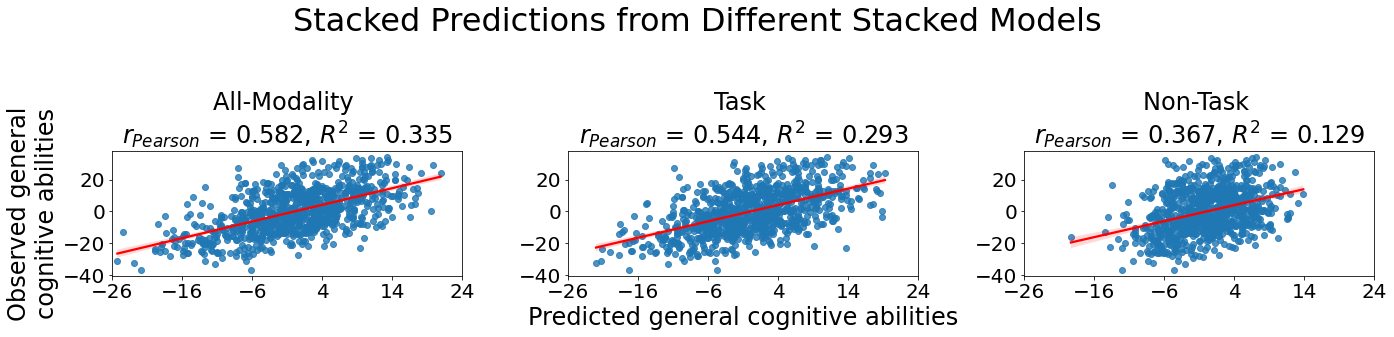

In [113]:
fig = plt.figure(figsize=(20,5))
plt.suptitle('Stacked Predictions from Different Stacked Models',fontsize=32)

plt.subplot(1,3,1)
col='set1'
crr, _ = pearsonr(df_y_all['y_real'], df_y_all[col])
sns.regplot(x=col, y='y_real', data=df_y_all, fit_reg=True, line_kws={'color': 'red'}) 
plt.xticks(np.arange(-26, 26, 10), fontsize=20)
plt.yticks(fontsize=20)
#plt.xlabel('Predicted\ngeneral cognitive abilities', fontsize=21)
plt.xlabel(' ')
plt.ylabel('Observed general\ncognitive abilities', fontsize=24)
plt.title('All-Modality '+'\n'+'$r_{Pearson}$ = '+str(df_mper.loc['All-Modality Stacked Model','cor'].round(3))+', $R^2$ = '+str(df_mper.loc['All-Modality Stacked Model','r2'].round(3)), fontsize=24)

plt.subplot(1,3,2)
col = 'set2'  
crr, _ = pearsonr(df_y_all['y_real'], df_y_all[col])
sns.regplot(x=col, y='y_real', data=df_y_all, fit_reg=True, line_kws={'color': 'red'}) 
plt.xticks(np.arange(-26, 26, 10), fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Predicted general cognitive abilities', fontsize=24)
#plt.ylabel('Observed\ngeneral cognitive abilities', fontsize=21)
plt.ylabel(' ')
plt.title('Task '+'\n'+'$r_{Pearson}$ = '+str(df_mper.loc['Task Stacked Model','cor'].round(3))+', $R^2$ = '+str(df_mper.loc['Task Stacked Model','r2'].round(3)), fontsize=24)

plt.subplot(1,3,3)
col = 'set3'
crr, _ = pearsonr(df_y_all['y_real'], df_y_all[col])
sns.regplot(x=col, y='y_real', data=df_y_all, fit_reg=True, line_kws={'color': 'red'}) 
plt.xticks(np.arange(-26, 26, 10), fontsize=20)
plt.yticks(fontsize=20)
#plt.xlabel('Predicted\ngeneral cognitive abilities', fontsize=21)
#plt.ylabel('Observed\ngeneral cognitive abilities', fontsize=21)  
plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Non-Task '+'\n'+'$r_{Pearson}$ = '+str(df_mper.loc['Non-Task Stacked Model','cor'].round(3))+', $R^2$ = '+str(df_mper.loc['Non-Task Stacked Model','r2'].round(3)), fontsize=24)

fig.tight_layout(pad=3.0)
plt.show()

In [17]:
#calculate difference between All Mods stacked model (set1) and others
#empty dict for storing results
dct_diff_boot_r2 = {}
dct_diff_boot_mse = {}
dct_diff_boot_mae = {}
dct_diff_boot_cor = {}
#doing subtraction
for col in bt_r2.columns:
    dct_diff_boot_r2['set1-'+str(col)] = bt_r2['set1'] - bt_r2[col]
    dct_diff_boot_mse['set1-'+str(col)] = bt_mse['set1'] - bt_mse[col]
    dct_diff_boot_mae['set1-'+str(col)] = bt_mae['set1'] - bt_mae[col]
    dct_diff_boot_cor['set1-'+str(col)] = bt_cor['set1'] - bt_cor[col]
#transform dict to tables
diff_boot_r2 = pd.DataFrame(dct_diff_boot_r2)
diff_boot_mse = pd.DataFrame(dct_diff_boot_mse)
diff_boot_mae = pd.DataFrame(dct_diff_boot_mae)
diff_boot_cor = pd.DataFrame(dct_diff_boot_cor)
#drop a redundant column
diff_boot_r2 = diff_boot_r2.drop('set1-set1', 1)
diff_boot_mse = diff_boot_mse.drop('set1-set1', 1)
diff_boot_mae = diff_boot_mae.drop('set1-set1', 1)
diff_boot_cor = diff_boot_cor.drop('set1-set1', 1)

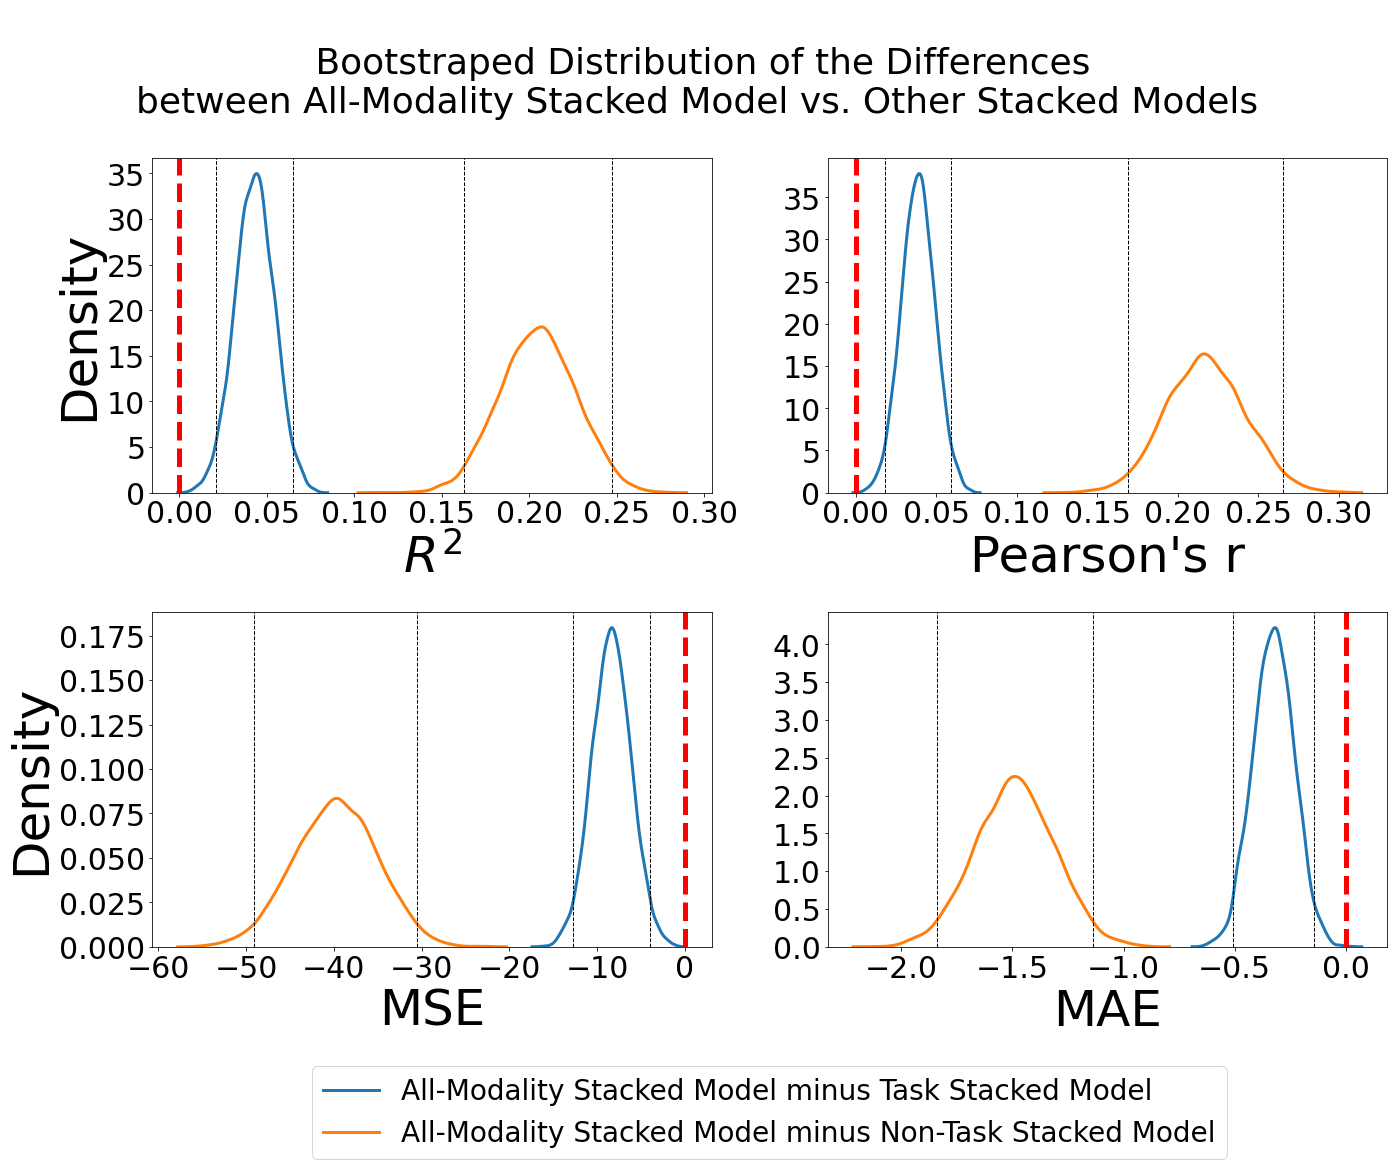

In [127]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
#plotting difference All Modality Stacked model Vs. other Stacked models
fig = plt.figure(figsize=(20,15))

plt.suptitle('\n Bootstraped Distribution of the Differences\nbetween All-Modality Stacked Model vs. Other Stacked Models',fontsize=36)

leg=['All-Modality Stacked Model minus Task Stacked Model', 'All-Modality Stacked Model minus Non-Task Stacked Model']

###
ax1 = plt.subplot(2,2,1)
dataset = diff_boot_r2.loc[:,('set1-set2', 'set1-set3')]

for col in dataset.columns:
    ax1 = sns.distplot(dataset[col], hist = False, kde = True,
                 kde_kws = {'linewidth': 3})
ax1 = plt.axvline(0, color='r', linestyle='dashed', linewidth=5)

data=dataset[dataset.mean().sort_values(ascending=True).index[0]]
a95, a05 = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=np.std(data))
ax1 = plt.axvline(a95, color='black', linestyle='dashed', linewidth=1)
ax1 = plt.axvline(a05, color='black', linestyle='dashed', linewidth=1)

data=dataset[dataset.mean().sort_values(ascending=True).index[1]]
a95, a05 = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=np.std(data))
ax1 = plt.axvline(a95, color='black', linestyle='dashed', linewidth=1)
ax1 = plt.axvline(a05, color='black', linestyle='dashed', linewidth=1)

#plt.title('95%CI for the best modality \n Tasks = ('+str(a95.round(2))+', '+str(a05.round(2))+')', fontsize=22)
plt.xlabel('$R^2$', fontsize=50)
plt.ylabel('Density', fontsize=50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
###

###
ax2 = plt.subplot(2,2,2)
dataset = diff_boot_cor.loc[:,('set1-set2', 'set1-set3')]

for col in dataset.columns:
    ax2 = sns.distplot(dataset[col], hist = False, kde = True,
                 kde_kws = {'linewidth': 3})
ax2 = plt.axvline(0, color='r', linestyle='dashed', linewidth=5)

data=dataset[dataset.mean().sort_values(ascending=True).index[0]]
a95, a05 = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=np.std(data))
ax2 = plt.axvline(a95, color='black', linestyle='dashed', linewidth=1)
ax2 = plt.axvline(a05, color='black', linestyle='dashed', linewidth=1)

data=dataset[dataset.mean().sort_values(ascending=True).index[1]]
a95, a05 = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=np.std(data))
ax2 = plt.axvline(a95, color='black', linestyle='dashed', linewidth=1)
ax2 = plt.axvline(a05, color='black', linestyle='dashed', linewidth=1)

#plt.title('95%CI for the best modality \n Tasks = ('+str(a95.round(2))+', '+str(a05.round(2))+')', fontsize=22)
plt.xlabel("Pearson's r", fontsize=50)
plt.ylabel(' ')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
###

###
ax3 = plt.subplot(2,2,3)

dataset = diff_boot_mse.loc[:,('set1-set2', 'set1-set3')]

for col in dataset.columns:
    ax3 = sns.distplot(dataset[col], hist = False, kde = True,
                 kde_kws = {'linewidth': 3})
ax3 = plt.axvline(0, color='r', linestyle='dashed', linewidth=5)

data=dataset[dataset.mean().sort_values(ascending=False).index[0]]
a95, a05 = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=np.std(data))
ax3 = plt.axvline(a95, color='black', linestyle='dashed', linewidth=1)
ax3 = plt.axvline(a05, color='black', linestyle='dashed', linewidth=1)

data=dataset[dataset.mean().sort_values(ascending=False).index[1]]
a95, a05 = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=np.std(data))
ax3 = plt.axvline(a95, color='black', linestyle='dashed', linewidth=1)
ax3 = plt.axvline(a05, color='black', linestyle='dashed', linewidth=1)

#plt.legend(leg, bbox_to_anchor=(1.97, 1.025), loc='upper right', fontsize=20)
#plt.title('95%CI for the best modality \n Tasks = ('+str(a95.round(2))+', '+str(a05.round(2))+')', fontsize=22)
plt.xlabel('MSE', fontsize=50)
plt.ylabel('Density', fontsize=50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
###

###
ax4 = plt.subplot(2,2,4)
dataset = diff_boot_mae.loc[:,('set1-set2', 'set1-set3')]

for col in dataset.columns:
    ax4 = sns.distplot(dataset[col], hist = False, kde = True,
                 kde_kws = {'linewidth': 3})
ax4 = plt.axvline(0, color='r', linestyle='dashed', linewidth=5)

data=dataset[dataset.mean().sort_values(ascending=False).index[0]]
a95, a05 = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=np.std(data))
ax4 = plt.axvline(a95, color='black', linestyle='dashed', linewidth=1)
ax4 = plt.axvline(a05, color='black', linestyle='dashed', linewidth=1)

data=dataset[dataset.mean().sort_values(ascending=False).index[1]]
a95, a05 = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=np.std(data))
ax4 = plt.axvline(a95, color='black', linestyle='dashed', linewidth=1)
ax4 = plt.axvline(a05, color='black', linestyle='dashed', linewidth=1)

#plt.title('95%CI for the best modality \n Tasks = ('+str(a95.round(2))+', '+str(a05.round(2))+')', fontsize=22)
plt.xlabel('MAE', fontsize=50)
plt.ylabel(' ')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
###

fig.tight_layout(pad=3.0)
fig.legend(leg,bbox_to_anchor=(0.55, -0.1),  loc='lower center', fontsize=28)
plt.show()

In [19]:
dct_CI_diff_r2={}
dataset = diff_boot_r2
for col in dataset.columns:
    data = dataset[col]
    a95, a05 = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=np.std(data))
    dct_CI_diff_r2[data.name] = a95, a05
    
dct_CI_diff_cor={}
dataset = diff_boot_cor
for col in dataset.columns:
    data = dataset[col]
    a95, a05 = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=np.std(data))
    dct_CI_diff_cor[data.name] = a95, a05
    
dct_CI_diff_mse={}
dataset = diff_boot_mse
for col in dataset.columns:
    data = dataset[col]
    a95, a05 = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=np.std(data))
    dct_CI_diff_mse[data.name] = a95, a05
    
dct_CI_diff_mae={}
dataset = diff_boot_mae
for col in dataset.columns:
    data = dataset[col]
    a95, a05 = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=np.std(data))
    dct_CI_diff_mae[data.name] = a95, a05
    
    
df_CI_diff_r2 = pd.DataFrame(dct_CI_diff_r2, index=['CI lower bound', 'CI upper bound'])
df_CI_diff_cor = pd.DataFrame(dct_CI_diff_cor, index=['CI lower bound', 'CI upper bound'])
df_CI_diff_mse = pd.DataFrame(dct_CI_diff_mse, index=['CI lower bound', 'CI upper bound'])
df_CI_diff_mae = pd.DataFrame(dct_CI_diff_mae, index=['CI lower bound', 'CI upper bound'])

In [20]:
df_CI_comb = pd.concat([df_CI_diff_r2, df_CI_diff_cor, df_CI_diff_mse, df_CI_diff_mae], axis=0)
df_CI_comb_m =df_CI_comb.set_index([(["$R^2$"] * 2 + ["Pearson's r"] * 2 + ['MSE'] * 2 + ['MAE'] * 2), df_CI_comb.index]) 
print('Table of Confidence Interval Meanings for Each Pairs of Bootstrapped Difference \nbetween All-Modality Stacked Model vs. Another Modality')
display(df_CI_comb_m.T)

Table of Confidence Interval Meanings for Each Pairs of Bootstrapped Difference 
between All-Modality Stacked Model vs. Another Modality


$R^2$                   Pearson's r                 \
              CI lower bound CI upper bound CI lower bound CI upper bound   
set1-emo            0.226964       0.321509       0.268786       0.390111   
set1-gam            0.287914       0.386905       0.502591       0.659190   
set1-lan            0.122439       0.210078       0.119353       0.214356   
set1-mot            0.225793       0.321952       0.260823       0.387183   
set1-rel            0.175506       0.267555       0.185455       0.292949   
set1-soc            0.231769       0.323216       0.272732       0.396117   
set1-wm             0.086536       0.166321       0.081697       0.162219   
set1-cort           0.286554       0.384565       0.430755       0.570807   
set1-subc           0.263664       0.360979       0.355727       0.489683   
set1-surf           0.236011       0.335193       0.287959       0.413890   
set1-rest           0.176038       0.262857       0.184594       0.287352   
set1-VolBrain       0.249694       0.349155       0.317787       0.454705   
set1-set2           0.020969       0.065195       0.018099       0.059208   
set1-set3           0.162664       0.247483       0.169346       0.265499   

                         MSE                           MAE                 
              CI lower bound CI upper bound CI lower bound CI upper bound  
set1-emo          -64.208389     -42.261281      -2.383502      -1.570709  
set1-gam          -78.032613     -53.000646      -2.726269      -1.863126  
set1-lan          -41.593090     -22.966142      -1.450219      -0.770356  
set1-mot          -64.482491     -41.869609      -2.353446      -1.531440  
set1-rel          -53.331060     -32.694451      -1.881956      -1.147370  
set1-soc          -64.872563     -42.884895      -2.285744      -1.489837  
set1-wm           -32.571721     -16.484017      -1.334047      -0.706964  
set1-cort         -77.260855     -53.024911      -2.705385      -1.864587  
set1-subc         -72.554436     -48.724926      -2.589522      -1.753180  
set1-surf         -66.840839     -44.031279      -2.431807      -1.609058  
set1-rest         -52.409829     -32.800890      -1.958374      -1.225387  
set1-VolBrain     -70.040959     -46.230174      -2.462250      -1.634681  
set1-set2         -12.715052      -4.002535      -0.506510      -0.143974  
set1-set3         -49.065533     -30.537602      -1.839871      -1.137581

#### 2. Performance of single modality and stacked models

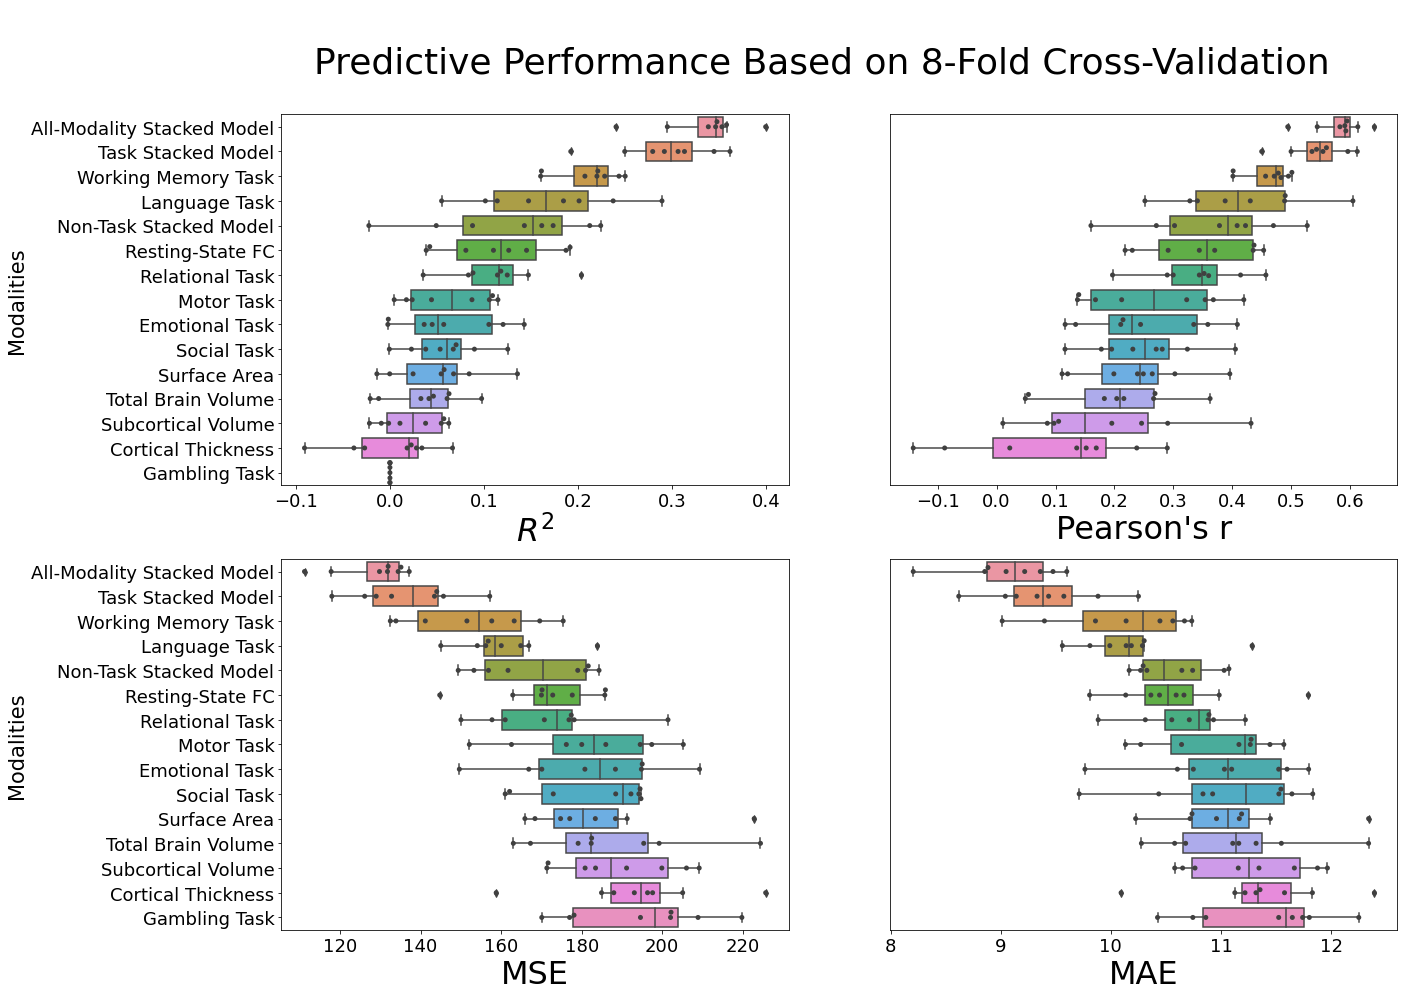

In [22]:
import warnings
warnings.filterwarnings('ignore')

df_r2.columns = lblY
df_cor.columns = lblY
df_mse.columns = lblY
df_mae.columns = lblY

sset1=df_r2.loc[:,df_r2.mean().sort_values(ascending=False).index]
sset2=df_cor.loc[:,df_cor.mean().sort_values(ascending=False).index]
sset3=df_mse.loc[:,df_mse.mean().sort_values(ascending=True).index]
sset4=df_mae.loc[:,df_mae.mean().sort_values(ascending=True).index]

plt.figure(figsize=(20,15))
plt.suptitle('\nPredictive Performance Based on 8-Fold Cross-Validation',fontsize=36)

plt.subplot(2,2,1)
#sset1.columns = leg_y
sns.boxplot(data=sset1, orient="h")
sns.swarmplot(data=sset1, color=".25", orient="h")
plt.xticks(fontsize=18) # 
plt.yticks(fontsize=18)
plt.xlabel('$R^2$', fontsize=32)
plt.ylabel('Modalities', fontsize=21)

plt.subplot(2,2,2)
#sset2.columns = leg_y
sns.boxplot(data=sset2, orient="h")
sns.swarmplot(data=sset2, color=".25", orient="h")
plt.xticks(fontsize=18)  
plt.yticks(fontsize=18)
ax = plt.gca()
ax.axes.yaxis.set_ticks([])
plt.xlabel("Pearson's r", fontsize=32)
#plt.ylabel('Modalities', fontsize=21)

plt.subplot(2,2,3)
#sset3.columns = leg_y
sns.boxplot(data=sset3, orient="h")
sns.swarmplot(data=sset3, color=".25", orient="h")
plt.xticks(fontsize=18) 
plt.yticks(fontsize=18)
plt.xlabel('MSE', fontsize=32)
plt.ylabel('Modalities', fontsize=21)

plt.subplot(2,2,4)
#sset4.columns = leg_y
sns.boxplot(data=sset4, orient="h")
sns.swarmplot(data=sset4, color=".25", orient="h")
plt.xticks(fontsize=18)  
#plt.yticks()
ax = plt.gca()
ax.axes.yaxis.set_ticks([])
plt.xlabel('MAE', fontsize=32)
#plt.ylabel('Modalities', fontsize=21)

plt.show()

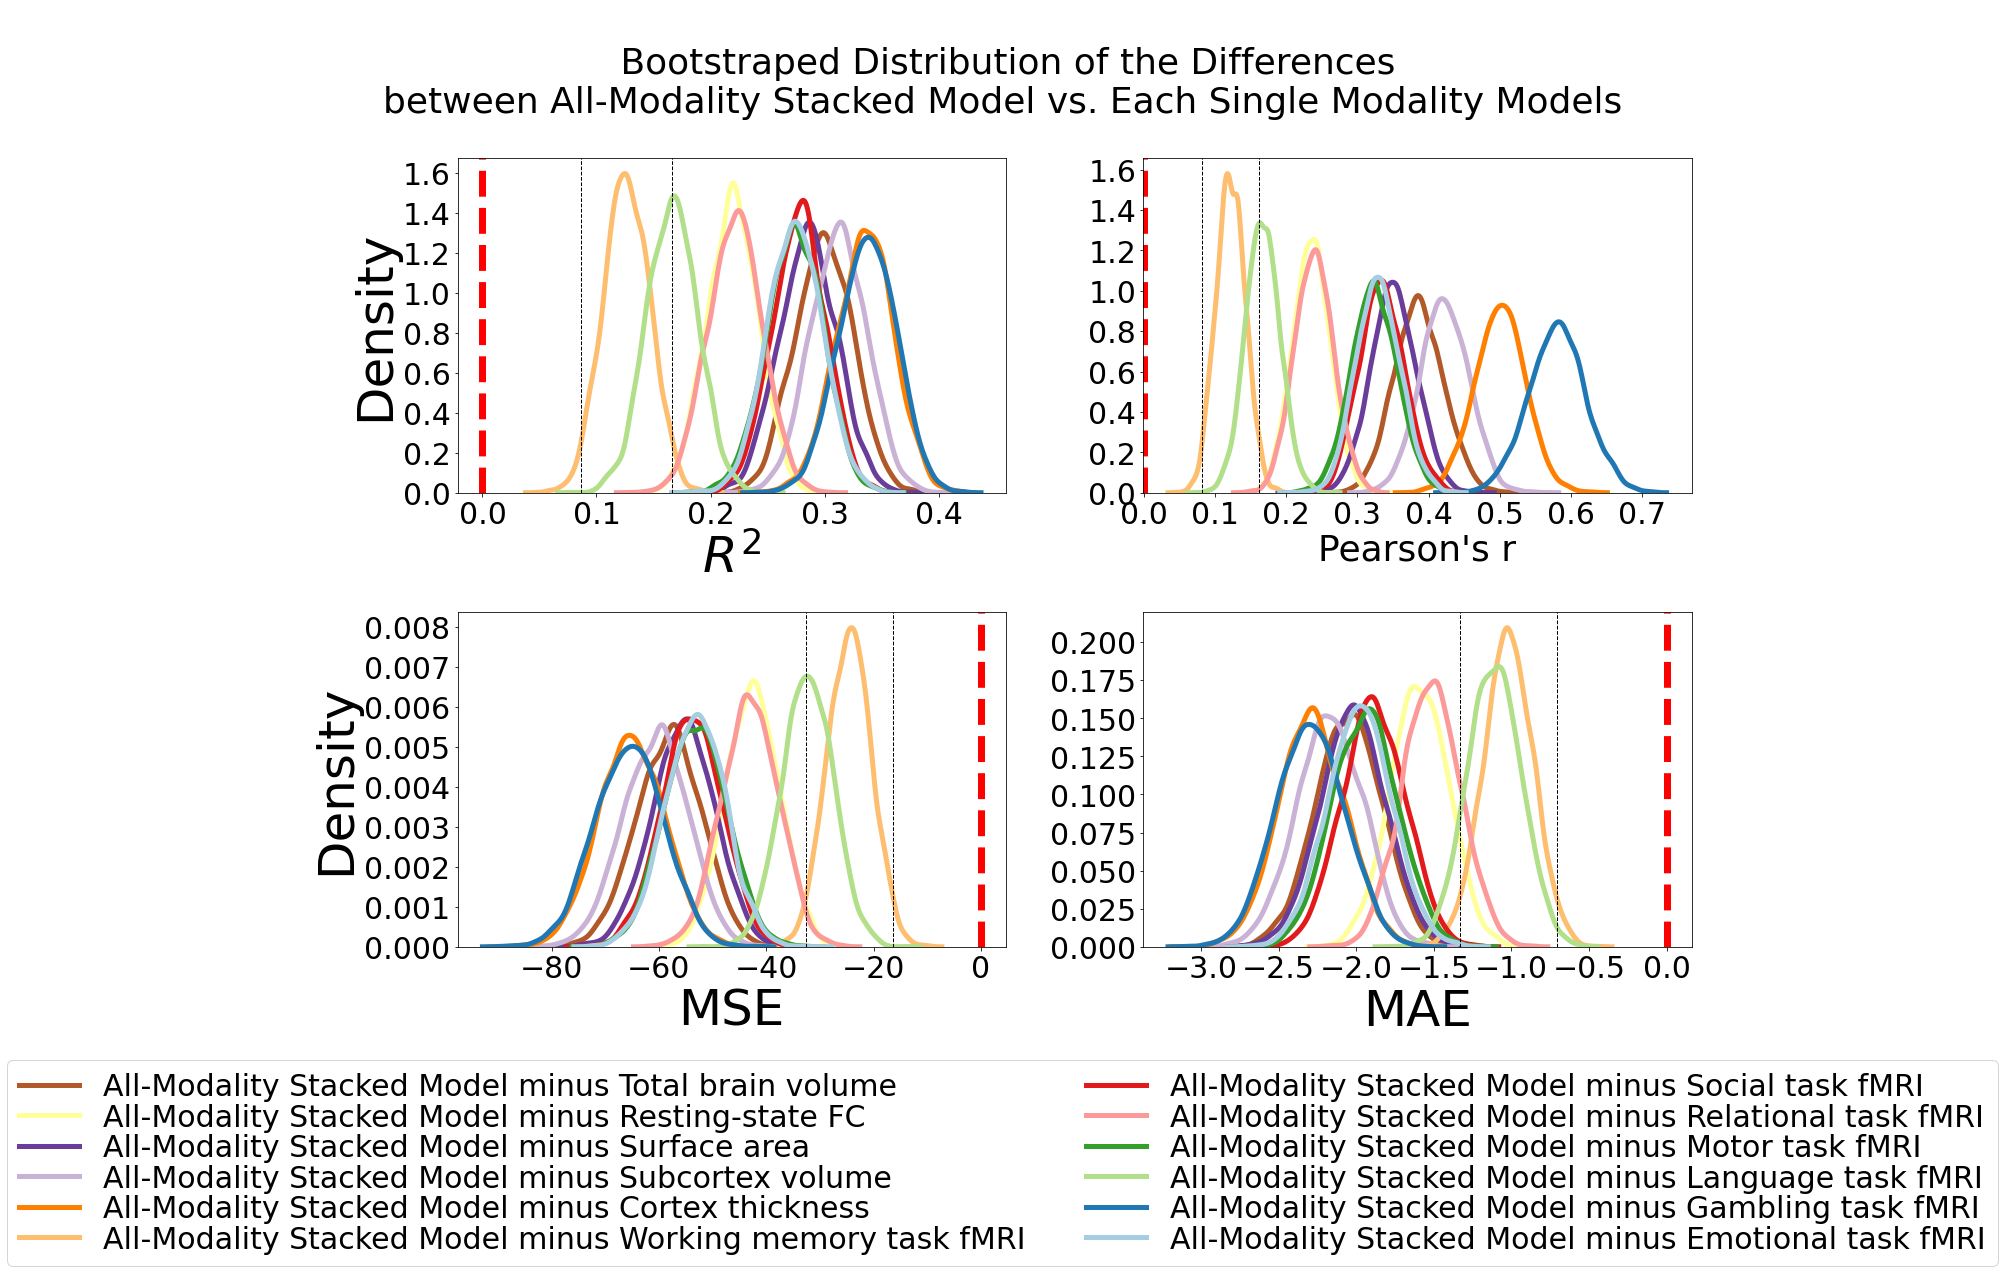

In [129]:
fig = plt.figure(figsize=(20,15))

plt.suptitle('\n Bootstraped Distribution of the Differences\nbetween All-Modality Stacked Model vs. Each Single Modality Models',fontsize=36)

leg=['All-Modality Stacked Model minus Emotional task fMRI', 'All-Modality Stacked Model minus Gambling task fMRI',
     'All-Modality Stacked Model minus Language task fMRI', 'All-Modality Stacked Model minus Motor task fMRI', 
     'All-Modality Stacked Model minus Relational task fMRI', 'All-Modality Stacked Model minus Social task fMRI', 
     'All-Modality Stacked Model minus Working memory task fMRI', 'All-Modality Stacked Model minus Cortex thickness', 
     'All-Modality Stacked Model minus Subcortex volume', 'All-Modality Stacked Model minus Surface area',
     'All-Modality Stacked Model minus Resting-state FC','All-Modality Stacked Model minus Total brain volume']

###
ax1 = plt.subplot(2,2,1)
dataset = diff_boot_r2.iloc[:,:-2]

palette = sns.color_palette("Paired")#sns.color_palette("nipy_spectral", len(dataset.columns))

ax1 = sns.kdeplot(data=dataset, palette = palette, legend=False, linewidth=5)

data=dataset[dataset.mean().sort_values(ascending=True).index[0]]
a95, a05 = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=np.std(data))

ax1 = plt.axvline(a95, color='black', linestyle='dashed', linewidth=1)
ax1 = plt.axvline(a05, color='black', linestyle='dashed', linewidth=1)
ax1 = plt.axvline(0, color='r', linestyle='dashed', linewidth=7)

#plt.title('95%CI for the best modality \n Working Memory Task  ['+str(a95.round(2))+', '+str(a05.round(2))+']', fontsize=22)
plt.xlabel('$R^2$', fontsize=50)
plt.ylabel('Density', fontsize=50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
###

###
ax2 = plt.subplot(2,2,2)
dataset = diff_boot_cor.iloc[:,:-2]

ax2 = sns.kdeplot(data=dataset, palette = palette, legend=False, linewidth=5)

data=dataset[dataset.mean().sort_values(ascending=True).index[0]]
a95, a05 = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=np.std(data))

ax2 = plt.axvline(a95, color='black', linestyle='dashed', linewidth=1)
ax2 = plt.axvline(a05, color='black', linestyle='dashed', linewidth=1)
ax2 = plt.axvline(0, color='r', linestyle='dashed', linewidth=7)

#plt.title('95%CI for the best modality \n Working Memory Task ['+str(a95.round(2))+', '+str(a05.round(2))+']', fontsize=22)
plt.xlabel("Pearson's r", fontsize=36)
plt.ylabel(' ')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
###

###
ax3 = plt.subplot(2,2,3)

dataset = diff_boot_mse.iloc[:,:-2]

ax3 = sns.kdeplot(data=dataset, palette = palette, legend=False, linewidth=5)

data=dataset[dataset.mean().sort_values(ascending=False).index[0]]
a95, a05 = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=np.std(data))

ax3 = plt.axvline(a95, color='black', linestyle='dashed', linewidth=1)
ax3 = plt.axvline(a05, color='black', linestyle='dashed', linewidth=1)
ax3 = plt.axvline(0, color='r', linestyle='dashed', linewidth=7)

#plt.title('95%CI for the best modality \n Working Memory Task ['+str(a95.round(2))+', '+str(a05.round(2))+']', fontsize=22)
plt.xlabel('MSE', fontsize=50)
plt.ylabel('Density', fontsize=50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
###

###
ax4 = plt.subplot(2,2,4)
dataset = diff_boot_mae.iloc[:,:-2]

ax4 = sns.kdeplot(data=dataset, palette = palette, legend=False, linewidth=5)

data=dataset[dataset.mean().sort_values(ascending=False).index[0]]
a95, a05 = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=np.std(data))

ax4 = plt.axvline(a95, color='black', linestyle='dashed', linewidth=1)
ax4 = plt.axvline(a05, color='black', linestyle='dashed', linewidth=1)
ax4 = plt.axvline(0, color='r', linestyle='dashed', linewidth=7)

#plt.title('95%CI for the best modality \n Working Memory Task  ['+str(a95.round(2))+', '+str(a05.round(2))+']', fontsize=22)
plt.xlabel('MAE', fontsize=50)
plt.ylabel(' ')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
###

fig.tight_layout(pad=3.0)
fig.legend(leg[::-1], bbox_to_anchor=(0.5, -0.2), loc='lower center', fontsize=30, ncol=2, labelspacing=0.05)
plt.show()

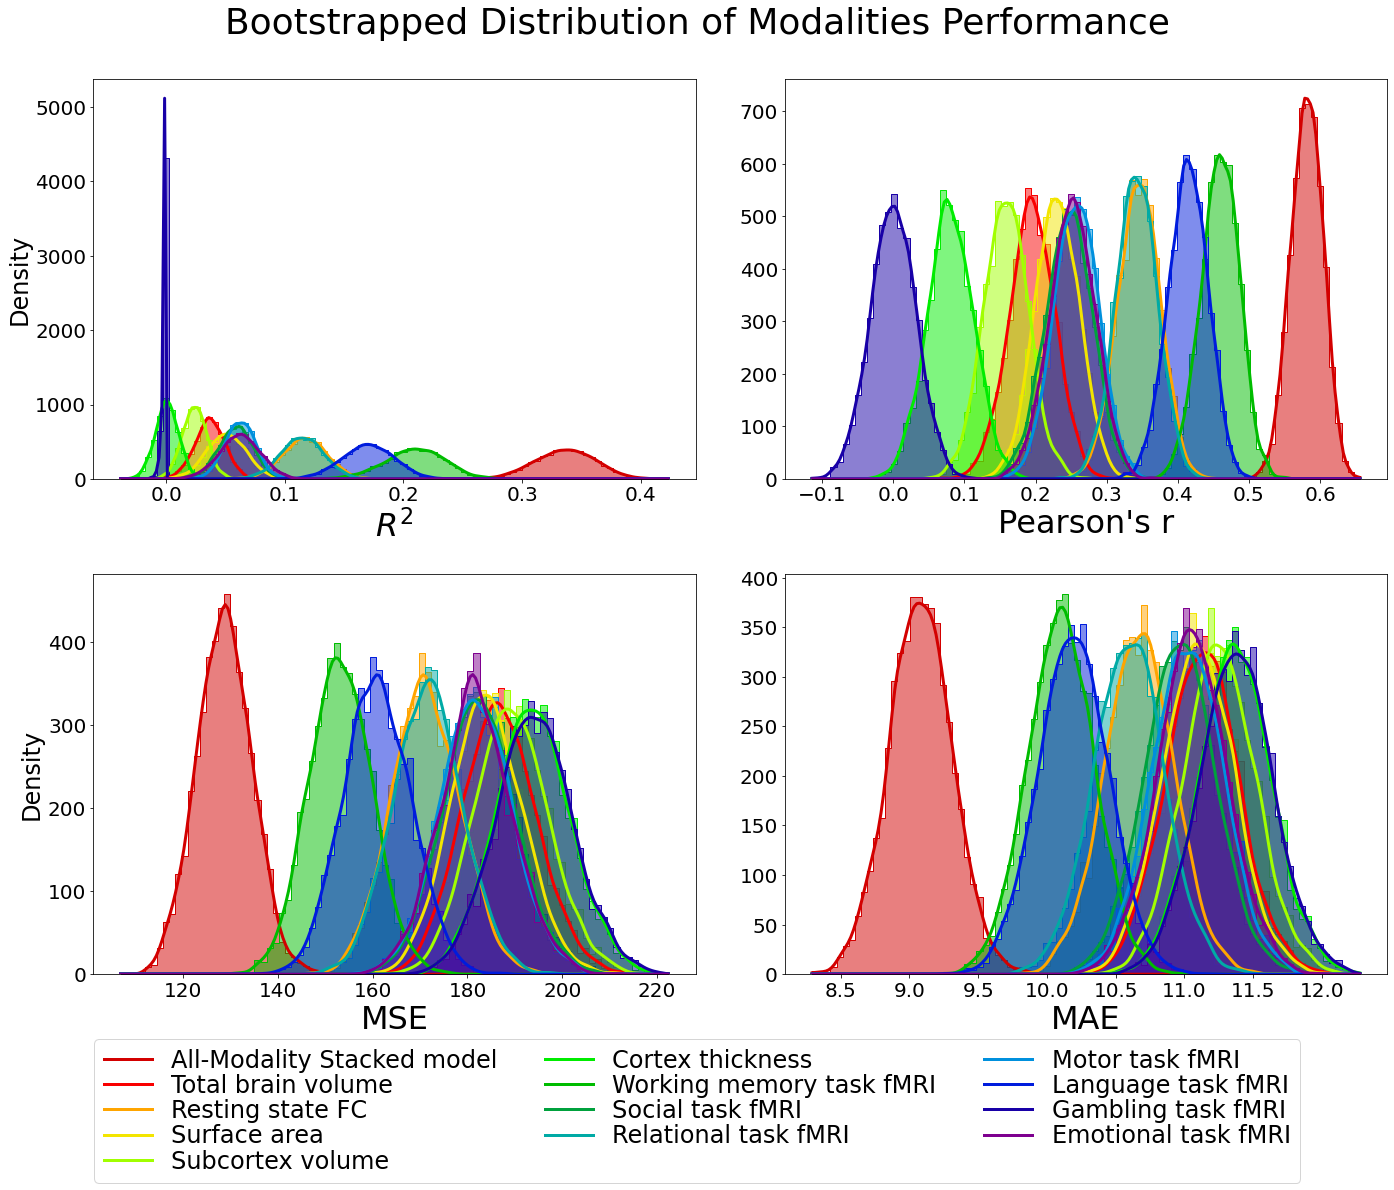

In [24]:
fig = plt.figure(figsize=(20,15))

plt.suptitle('Bootstrapped Distribution of Modalities Performance',fontsize=36)

leg=['Emotional task fMRI', 'Gambling task fMRI', 'Language task fMRI', 'Motor task fMRI', 
     'Relational task fMRI', 'Social task fMRI', 'Working memory task fMRI', 'Cortex thickness', 
     'Subcortex volume', 'Surface area',
       'Resting state FC','Total brain volume', 'All-Modality Stacked model']

palette = sns.color_palette("nipy_spectral", 13) #sns.color_palette('tab20b', 13)#sns.color_palette('gist_rainbow', 13)#sns.color_palette("gist_ncar", 13)

#= cmapp#'tab20'#"Paired"#'muted'#'colorblind'#"turbo" #'nipy_spectral' #'terrain' #'gist_rainbow' #"Spectral"
###
ax1 = plt.subplot(2,2,1)
dataset = bt_r2.iloc[:,:-2]
dataset.columns=leg
#ordr = dataset.mean().sort_values(ascending=False).index
#dataset = dataset.loc[:, ordr]

ax1= sns.histplot(dataset, kde=True, element='step', bins=90, line_kws={'linewidth':3}, legend=False,palette=palette)
plt.xlabel('$R^2$', fontsize=32)
plt.ylabel('Density', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
###

###
ax2 = plt.subplot(2,2,2)
dataset = bt_cor.iloc[:,:-2]
dataset.columns=leg
#dataset = dataset.loc[:, ordr]

ax2= sns.histplot(dataset, kde=True, element='step', bins=90, line_kws={'linewidth':3}, legend=False,palette=palette)
plt.xlabel("Pearson's r", fontsize=32)
plt.ylabel(' ')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
###

#plt.legend(leg, bbox_to_anchor=(1.97, 1.025), loc='upper right', fontsize=20)

###
ax3 = plt.subplot(2,2,3)
dataset = bt_mse.iloc[:,:-2]
dataset.columns=leg
#dataset = dataset.loc[:, ordr]

ax3= sns.histplot(dataset, kde=True, element='step', bins=90, line_kws={'linewidth':3}, legend=False,palette=palette)
plt.xlabel('MSE', fontsize=32)
plt.ylabel('Density', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
###

###
ax4 = plt.subplot(2,2,4)
dataset = bt_mae.iloc[:,:-2]
dataset.columns=leg
#dataset = dataset.loc[:, ordr]

ax4= sns.histplot(dataset, kde=True, element='step', bins=90, line_kws={'linewidth':3}, legend=False,palette=palette)
plt.xlabel('MAE', fontsize=32)
plt.ylabel(' ')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
###

fig.tight_layout(pad=3.0)
fig.legend(list(reversed(leg)), bbox_to_anchor=(0.5, -0.12), loc='lower center', fontsize=24, ncol=3, labelspacing=0.05)
plt.show()

#### 3. Feature coefficients order within models

##### Stacked Models

In [25]:
#read All Mods stacked model coeffs from each fold
dct_set1_coef = {}
for fold in folders:
    dct_set1_coef[fold] = (joblib.load(path2+fold+'/set1_stacked_model.sav')).named_steps['elasticnet'].coef_
set1_coef = pd.DataFrame(dct_set1_coef, index=bt_r2.columns[:-3]).T 
#save
set1_coef.to_csv(path2+'set1_stacked_coeffs.csv')
display(set1_coef.mean().sort_values(ascending=False))


wm          3.109366
rest        2.381095
lan         2.116654
rel         2.084762
surf        0.816825
emo         0.806605
mot         0.507791
soc         0.462631
cort        0.361008
VolBrain    0.261906
subc        0.258606
gam         0.000000
dtype: float64

In [26]:
#read Tasks stacked model coeffs from each fold
dct_set2_coef = {}
for fold in folders:
    dct_set2_coef[fold] = (joblib.load(path2+fold+'/set2_stacked_model.sav')).named_steps['elasticnet'].coef_
set2_coef = pd.DataFrame(dct_set2_coef, index=bt_r2.columns[:-8]).T 
#save
set2_coef.to_csv(path2+'set2_stacked_coeffs.csv')
display(set2_coef.mean().sort_values(ascending=False))

wm     3.454728
lan    2.678002
rel    2.517195
emo    0.939731
mot    0.768886
soc    0.462508
gam    0.000000
dtype: float64

In [27]:
#read Non-Tasks stacked model coeffs from each fold
dct_set3_coef = {}
for fold in folders:
    dct_set3_coef[fold] = (joblib.load(path2+fold+'/set3_stacked_model.sav')).named_steps['elasticnet'].coef_
set3_coef = pd.DataFrame(dct_set3_coef, index=bt_r2.columns[-8:-3]).T 
#save
set3_coef.to_csv(path2+'set3_stacked_coeffs.csv')
display(set3_coef.mean().sort_values(ascending=False))

rest        3.610581
surf        1.355449
cort        0.774197
VolBrain    0.764618
subc        0.488392
dtype: float64

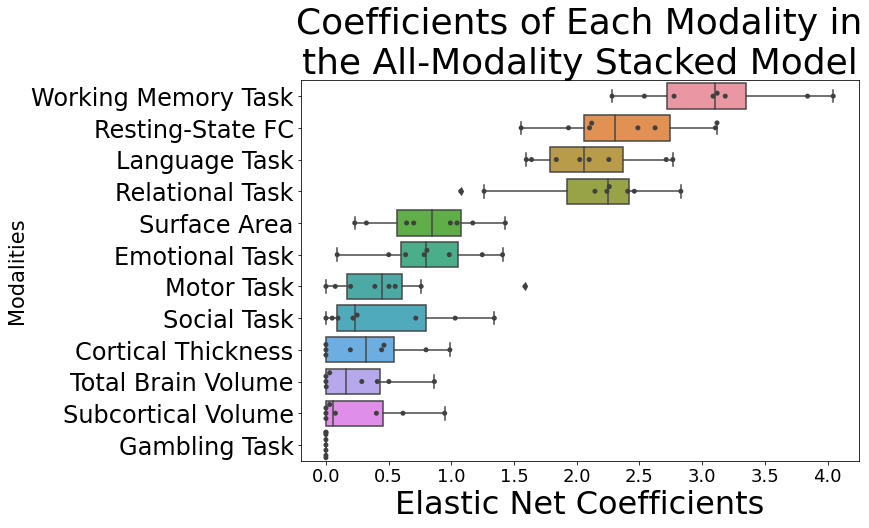

In [28]:
#plot stacked model coeffs
set1_coef.columns = lblY[:12]
d=set1_coef.loc[:,set1_coef.mean().sort_values(ascending=False).index]

plt.figure(figsize=(10,7))

sns.boxplot(data=d, orient="h")
sns.swarmplot(data=d, color=".25", orient="h")

plt.xticks(fontsize=18) #np.arange(5, 25, step=1), 
plt.yticks(fontsize=24)
plt.xlabel('Elastic Net Coefficients', fontsize=32)
plt.ylabel('Modalities', fontsize=21)
plt.title('Coefficients of Each Modality in\nthe All-Modality Stacked Model',fontsize=36)

plt.show()

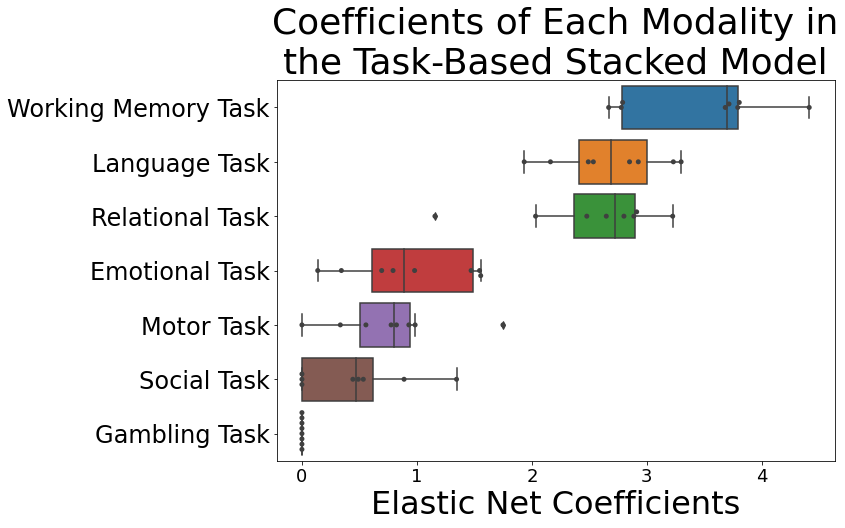

In [29]:
#plot stacked model coeffs
set2_coef.columns = lblY[:7]
d=set2_coef.loc[:,set2_coef.mean().sort_values(ascending=False).index]

plt.figure(figsize=(10,7))

sns.boxplot(data=d, orient="h")
sns.swarmplot(data=d, color=".25", orient="h")

plt.xticks(fontsize=18) #np.arange(5, 25, step=1), 
plt.yticks(fontsize=24)
plt.xlabel('Elastic Net Coefficients', fontsize=32)
#plt.ylabel('Modalities', fontsize=21)
plt.title('Coefficients of Each Modality in\nthe Task-Based Stacked Model',fontsize=36)

plt.show()

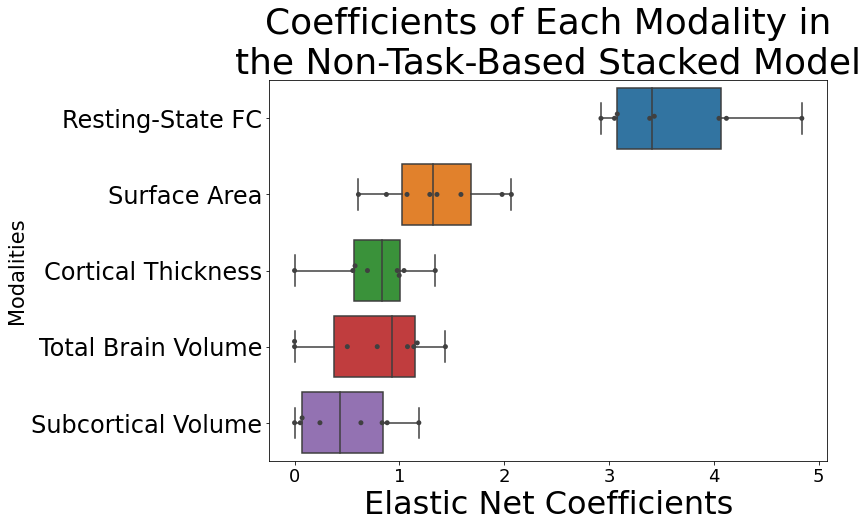

In [30]:
#plot stacked model coeffs
set3_coef.columns = lblY[7:12]
d=set3_coef.loc[:,set3_coef.mean().sort_values(ascending=False).index]

plt.figure(figsize=(10,7))

sns.boxplot(data=d, orient="h")
sns.swarmplot(data=d, color=".25", orient="h")

plt.xticks(fontsize=18) #np.arange(5, 25, step=1), 
plt.yticks(fontsize=24)
plt.xlabel('Elastic Net Coefficients', fontsize=32)
plt.ylabel('Modalities', fontsize=21)
plt.title('Coefficients of Each Modality in\nthe Non-Task-Based Stacked Model',fontsize=36)

plt.show()

##### Single Modality Models

In [34]:
#read coeffs from single modality models
dct_singleML_coeff = {}
for col in bt_r2.columns[:-3]:
    dct={}
    for fold in folders:
        dct[fold] = (joblib.load(path2+fold+'/'+str(col)+'_elnet_model.sav')).named_steps['elasticnet'].coef_
    df =  pd.DataFrame(dct).T
    df.columns = features[col].columns #from the beginning of the script before ML
    dct_singleML_coeff[col] = df

# save as separate tables    
for key in dct_singleML_coeff.keys():
    dct_singleML_coeff[key].to_csv(path2+str(key)+'_elnet_coeffs.csv')    

##### Total Brain Volume

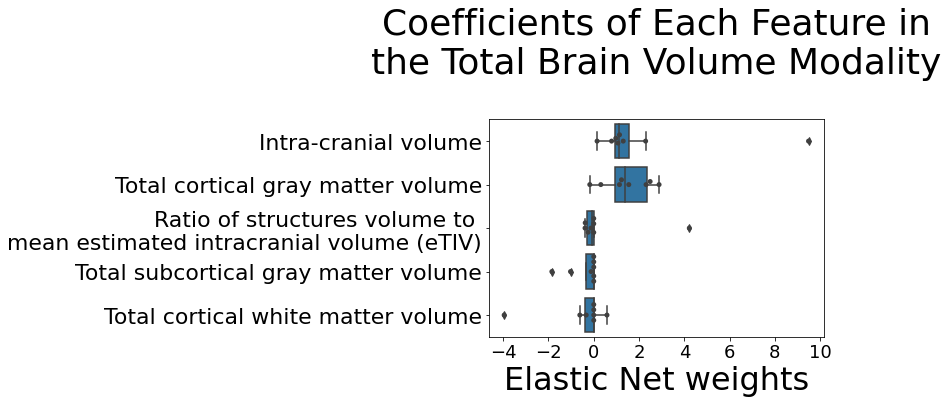

In [35]:
dct_singleML_coeff['VolBrain'].columns = ['Intra-cranial volume',
'Total cortical gray matter volume',
'Total subcortical gray matter volume',
'Total cortical white matter volume',
'Ratio of structures volume to \nmean estimated intracranial volume (eTIV)']

data = dct_singleML_coeff['VolBrain'].loc[:, dct_singleML_coeff['VolBrain'].mean().sort_values(ascending=False).index]
sns.boxplot(data=data, orient="h", color='tab:blue')
sns.swarmplot(data=data, color=".25", orient="h")

plt.xticks(fontsize=18)
plt.yticks(fontsize=22)
#plt.xlabel('', fontsize=21)
plt.xlabel('Elastic Net weights', fontsize=32)
plt.title('Coefficients of Each Feature in\nthe Total Brain Volume Modality\n',fontsize=36)

plt.show()

##### Tasks

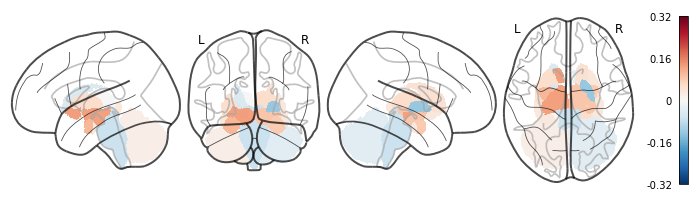

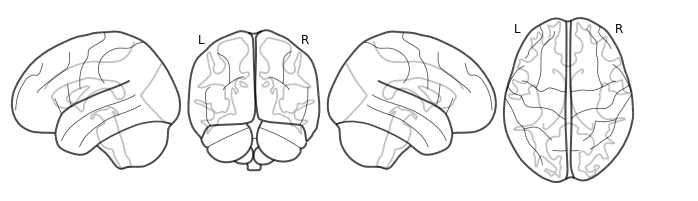

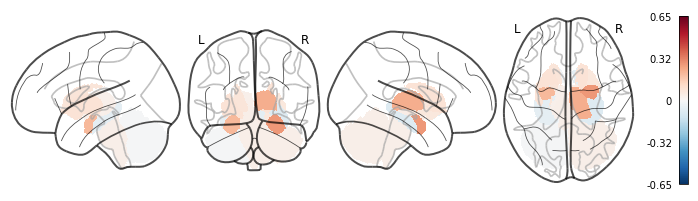

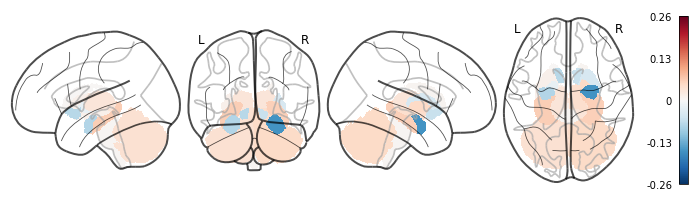

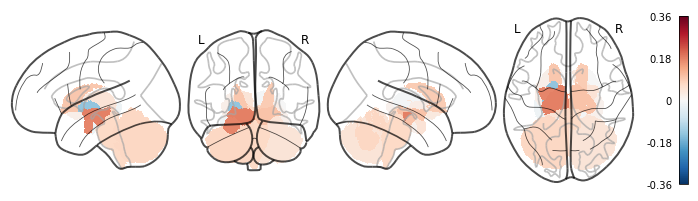

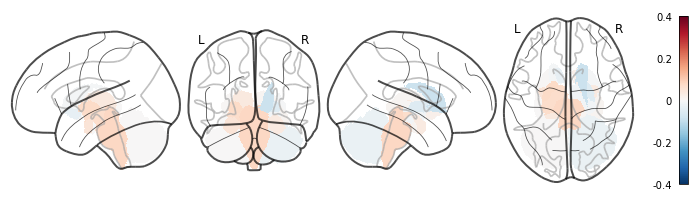

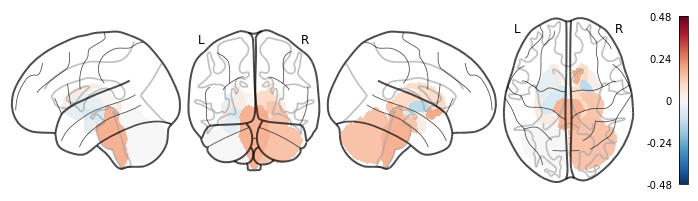

In [155]:
wway = '/home/narunlab/Documents/HCP_analysis/atlases/'

atlas = nli.load_img(wway+'MMP_in_MNI_corr.nii.gz')
atlas2 = nli.load_img(wway+'subc2.fs.nii.gz')

par_dat = atlas.get_fdata()
par_dat2 = atlas2.get_fdata()

nmri = 0
sbn = 1
mrilist = lblY[:7]

#fig, axes = plt.subplots(nrows=14, ncols=1)

for key in ['emo', 'gam', 'lan', 'mot', 'rel', 'soc', 'wm']:

    site_nii = np.zeros(par_dat.shape)
    site_nii2 = np.zeros(par_dat2.shape)
    
    #cortex according to atlas, 180:360 right hemisphere, 1:180 left. 
    vec = pd.Series(np.concatenate( [(dct_singleML_coeff[key].mean()[180:360]).values, np.zeros(20), (dct_singleML_coeff[key].mean()[0:180]).values]))
    #subcortex, the table has same order as atlas
    vec2 = pd.Series((dct_singleML_coeff[key].mean()[360:]).values, index=pd.read_csv(wway+'atlas_index_num.csv')['nn'].values )


    for index, numb in enumerate(vec): 
        site_nii[par_dat == (index+1)] = numb

    for index, numb in zip(vec2.index, vec2.iloc[:]): 
        site_nii2[par_dat2 == (index)] = numb

    site_img = nli.new_img_like(atlas, site_nii, atlas.affine, copy_header=True)

    site_img2 = nli.new_img_like(atlas2, site_nii2, atlas2.affine, copy_header=True)

    #display1 =plotting.plot_glass_brain(site_img, plot_abs=False, cmap='RdBu_r', colorbar=True, display_mode='lyrz', vmin=min(dct_singleML_coeff[key].mean()), vmax=max(dct_singleML_coeff[key].mean()))#, title=mrilist[nmri]+' cortex')
    display2 = plotting.plot_glass_brain(site_img2, plot_abs=False, cmap='RdBu_r', colorbar=True, display_mode='lyrz', vmin=min(dct_singleML_coeff[key].mean()), vmax=max(dct_singleML_coeff[key].mean()))#, title=mrilist[nmri]+' subcortex')
    
    plotting.show()
        
    sbn+=2
    nmri+=1

In [39]:
#save each modality mean feature coefficients as vector to txt for next plotting
for key in list(dct_singleML_coeff.keys())[:7]:
    dct_singleML_coeff[key].mean()[0:360].to_csv(path2+'mean_'+str(key)+'_cortex_gla_elnet_coeffs_nums.txt', header=None, index=None)

In [40]:
#create cifti files for cortex brain image for glasses atlas

#read files with path
brain_files = list(glob.glob(path2+'*_cortex_gla_elnet_coeffs_nums.csv'))
#mod names
mod_brain_files = [b.split('/')[-1].split('_')[1] for b in brain_files]
#create cifti files with wb_commands
for i in range(len(brain_files)):
    cmd = 'wb_command -cifti-convert -from-text '+str(brain_files[i])+' '+wway+'glasser_cifti_empty_template.ptseries.nii' +' '+path2+'mean_'+str(mod_brain_files[i])+'_cortex_gla_elnet_coeffs.ptseries.nii'
    os.system(cmd)

##### Anatomical (Non-Tasks) Modalities

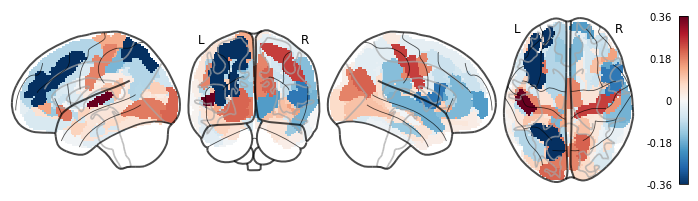

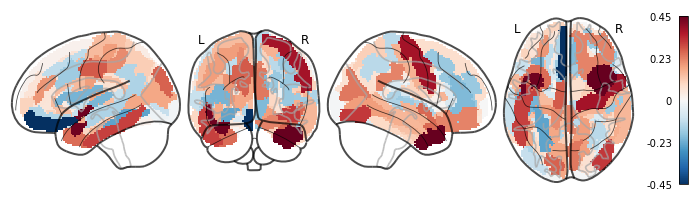

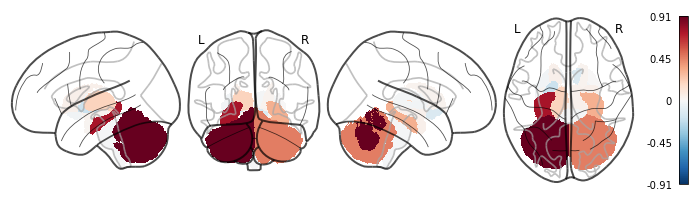

In [150]:
atlas = nli.load_img(wway+'destrieux2009_rois_lateralized.nii.gz')
atlas2 = nli.load_img(wway+'subc2.fs.nii.gz')

par_dat = atlas.get_fdata()

nms = ['Cortical thickness', 'Surface area']
nn=0
for key in ['cort', 'surf']:
    
    site_nii = np.zeros(par_dat.shape)

    #add to columns the med.wall label to match with nii atlas order
    vec = dct_singleML_coeff[key].mean().reindex(index=np.loadtxt(wway+'destrieux2009_new_header_for_table_with_med_wall.txt',dtype=str)).fillna(0)

    for index, numb in enumerate(vec): 
        site_nii[par_dat == (index+1)] = numb

    site_img = nli.new_img_like(atlas, site_nii, atlas.affine, copy_header=True)
    
    #print(key)
    display_fs = plotting.plot_glass_brain(site_img, plot_abs=False, cmap='RdBu_r', colorbar=True, display_mode='lyrz', vmin=min(vec), vmax=max(vec))#, title=nms[nn]
    plotting.show()
    nn+=1
par_dat2 = atlas2.get_fdata()
site_nii2 = np.zeros(par_dat2.shape)

#reorder subc table into atlas order
v2 = dct_singleML_coeff['subc'].mean().reindex(index = ['Left-Accumbens-area',
'Right-Accumbens-area',
'Left-Amygdala',
'Right-Amygdala',
'Brain-Stem',
'Left-Caudate',
'Right-Caudate',
'Left-Cerebellum-Cortex',
'Right-Cerebellum-Cortex',
'Left-VentralDC',
'Right-VentralDC',
'Left-Hippocampus',
'Right-Hippocampus',
'Left-Pallidum',
'Right-Pallidum',
'Left-Putamen',
'Right-Putamen',
'Left-Thalamus-Proper',
'Right-Thalamus-Proper'])

vec2 =pd.Series(v2.values, index=pd.read_csv(wway+'atlas_index_num.csv')['nn'].values )

for index, numb in zip(vec2.index, vec2.iloc[:]): 
    site_nii2[par_dat2 == (index)] = numb

site_img2 = nli.new_img_like(atlas2, site_nii2, atlas2.affine, copy_header=True)

#print('subc')
display_subc = plotting.plot_glass_brain(site_img2, plot_abs=False, cmap='RdBu_r', colorbar=True, display_mode='lyrz', vmin=min(vec2), vmax=max(vec2))#, title='Subcortical volume'
plotting.show()

##### Resting State FC

In [221]:
rest_vec = dct_singleML_coeff['rest'].mean()

In [199]:
#tab1 = dct_singleML_coeff['rest'].mean().abs().sort_values(ascending=False)[:20]
#rest_vec = dct_singleML_coeff['rest'].mean().reindex(index = tab1.index)

In [222]:
#load all column index from rest table beforefiltering
full_rest_indx = pd.read_csv(path+'rest_table.csv', index_col=0).columns

#load matching table between Glasser and Cole atlas
tbl_gla_cole = pd.read_csv(wway+'Glasser-Cole_match_table.csv')

In [223]:
rest_vec_ind_sh = list(rest_vec.index)
print(len(rest_vec_ind_sh))

2908


In [234]:
tbl_gla_cole

orig_order  left_first_order  Cole_net_order name_Glasser  \
0             1               181               1     R_V1_ROI   
1             2               182               2    R_MST_ROI   
2             3               183               2     R_V6_ROI   
3             4               184               2     R_V2_ROI   
4             5               185               2     R_V3_ROI   
..          ...               ...             ...          ...   
355         356               176               9  L_STSva_ROI   
356         357               177               9   L_TE1m_ROI   
357         358               178               4     L_PI_ROI   
358         359               179               4  L_a32pr_ROI   
359         360               180               4    L_p24_ROI   

         Cole_net_name  
0              Visual1  
1              Visual2  
2              Visual2  
3              Visual2  
4              Visual2  
..                 ...  
355            Default  
356            Default  
357  Cingulo-Opercular  
358  Cingulo-Opercular  
359  Cingulo-Opercular  

[360 rows x 5 columns]

In [224]:
full_rest_indx = list(full_rest_indx)
#print(full_rest_indx)

In [235]:
#add back all FC labels before filtering
rest_vec = rest_vec.reindex(index=full_rest_indx)
for i in rest_vec_ind_sh:
    rest_vec[i] = dct_singleML_coeff['rest'].mean().loc[i]
    #print(i)
    #print(rest_vec.loc[i], dct_singleML_coeff['rest'].mean().loc[i])
#display(max(rest_vec))
 
#reconstruct back the FC corr matrix
k=378
i = 0
matx = {}
j=0
while k >= 1:
    if i == 0:
        idxh = [nm.split('-')[1] for nm in rest_vec.index[i : i+k]]
    
    matx[rest_vec.index[i].split('-')[0]] = pd.Series(np.array(rest_vec[rest_vec.index[i : i+k]]), index=idxh[j:])
    
    i=i+k
    k-=1
    j+=1
#upper part of matrix is created
df_matx = pd.DataFrame(matx).T.loc[:, idxh]
df_matx = df_matx.reindex(index = np.append(list([df_matx.index[0]]), list(df_matx.columns)),
                         columns = np.append(list([df_matx.index[0]]), list(df_matx.columns)))
#create the lower part and combine into one full matrix (to compensate index shuffling)
A = np.array(df_matx) # upper half
B = np.array(df_matx.T) #lower half
rest_matx = pd.DataFrame(np.where(np.isnan(A), B, A + np.nan_to_num(B)), index = df_matx.index, columns = df_matx.columns)

#sort indexes in matrix according Cole net atlas
cole_ord_fs_subc = np.append(np.array(tbl_gla_cole.sort_values(by=['Cole_net_order','left_first_order'])['name_Glasser']),
                             np.array(df_matx.index[-19:]))

rest_matx_sort = rest_matx.reindex(index = cole_ord_fs_subc, columns = cole_ord_fs_subc)

#leave only upper triangle again
rest_matx_sort_up = rest_matx_sort.where(np.triu(np.ones(rest_matx_sort.shape)).astype(np.bool))

#assign second level index to index and columns
nums = np.append(np.array(tbl_gla_cole.sort_values(by=['left_first_order']).sort_values(by=['Cole_net_order'])['Cole_net_order']),
                 np.full((19),13)) #numbers of brain networks

rest_matx_sort_up_mult = rest_matx_sort_up.set_index([nums, rest_matx_sort_up.index])
rest_matx_sort_up_mult = rest_matx_sort_up_mult.T.set_index([nums, rest_matx_sort_up.columns]).T

#shrink empty rows and columns
t=rest_matx_sort_up_mult
for ind in t.index:
    nmx = t.loc[ind,:].isna().sum()
    if nmx >= len(t.columns):
        t= t.drop([ind], axis=0)
for col in t.columns:
    nmy = t.loc[:,col].isna().sum()
    if nmy >= len(t.index):
        del t[col]
rest_matx_sort_up_mult_shr = t
print(rest_matx_sort_up_mult_shr.shape)


(273, 254)


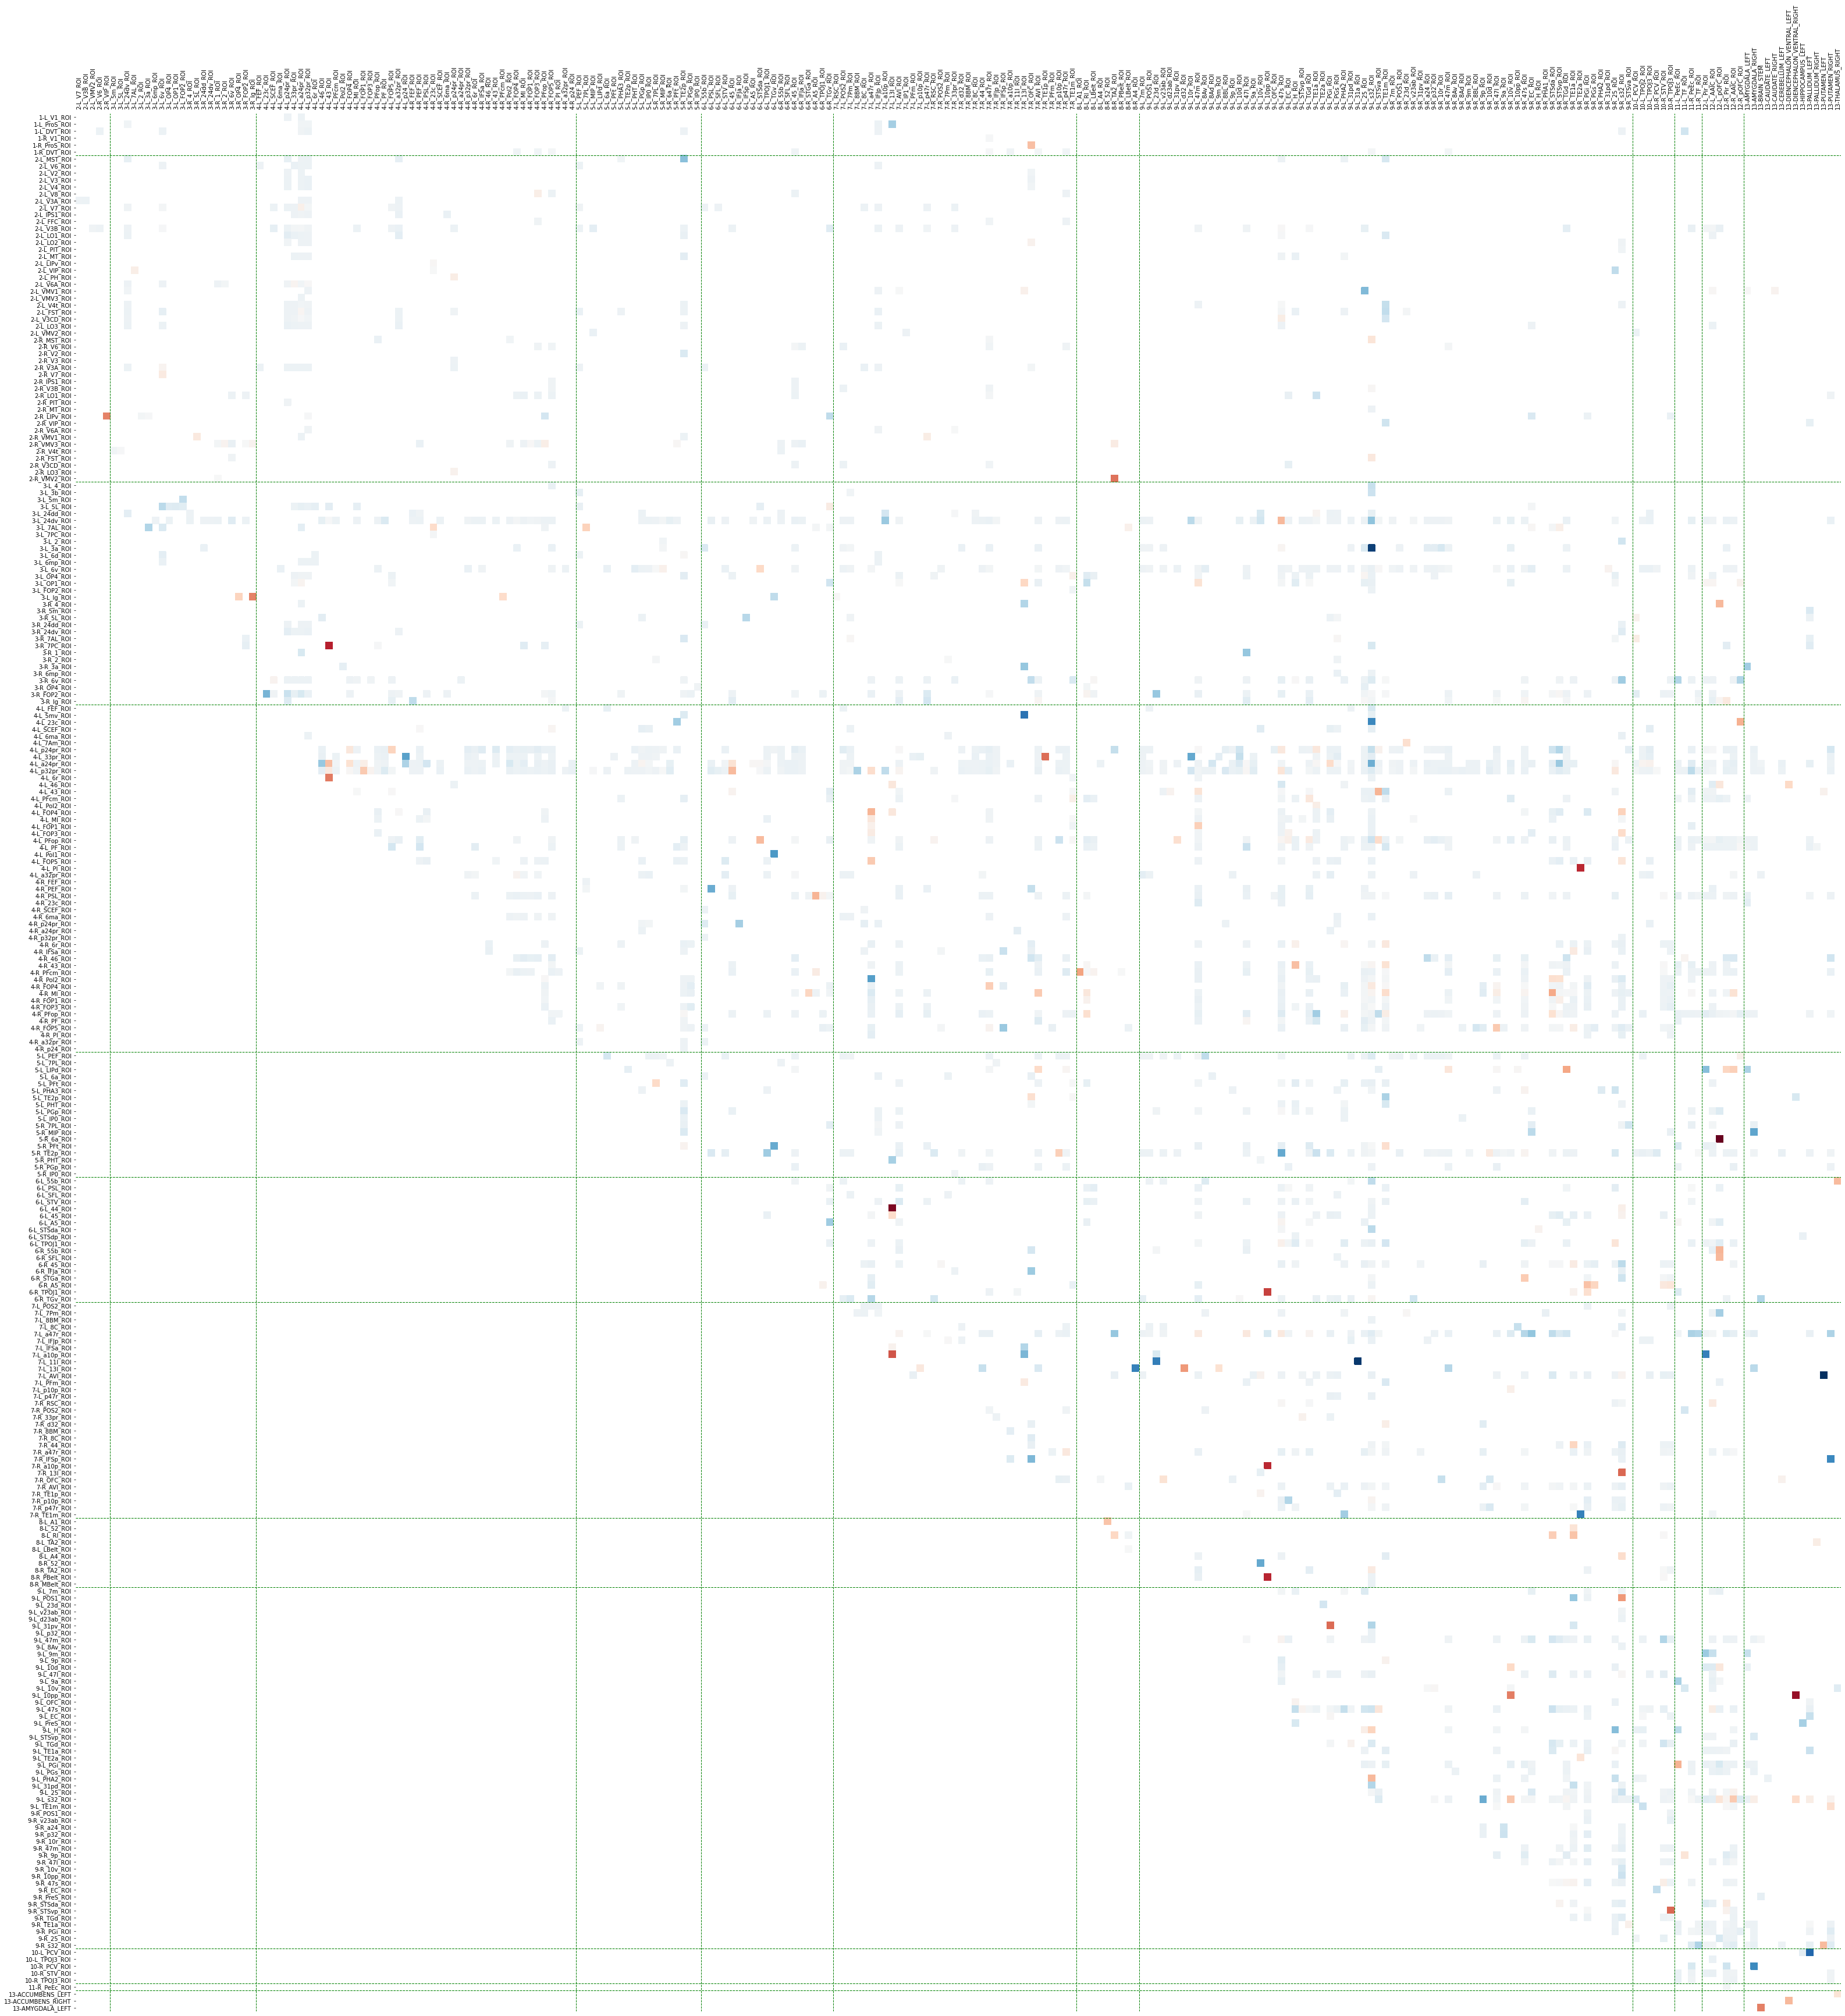

In [237]:
plt.figure(figsize=(60,60))
sns.heatmap(rest_matx_sort_up_mult_shr,cmap='RdBu_r', square=True, cbar=False)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.xticks(rotation='vertical')

#ax = plt.gca()
#ax.axes.yaxis.set_ticks([])

k=0
for i in sorted(set([c[0] for c in rest_matx_sort_up_mult_shr.index]))[:-1]:
    line_place_ind = rest_matx_sort_up_mult_shr.loc[(i, slice(None)), :].shape[0]
    k = k+line_place_ind
    #print(k)
    plt.axhline(y = k, color ="green", linestyle ="--",linewidth=1, label= net_fs_labl[i])
    #print(net_fs_labl[i])
    
k=0    
for i in sorted(set([c[0] for c in rest_matx_sort_up_mult_shr.columns]))[:-1]:
    line_place_col = rest_matx_sort_up_mult_shr.loc[:,(i, slice(None))].shape[1]
    k = k+line_place_col
    #print(k)
    plt.axvline(x = k, color ="green", linestyle ="--",linewidth=1, label= net_fs_labl[i])

    
plt.ylabel(None)
plt.xlabel(None)
plt.show()
#lt.xticks(xticks.keys(),xticks.values() rest_matx_sort_up_mult_shr[(rest_matx_sort_up_mult_shr>0.07) | (rest_matx_sort_up_mult_shr<-0.07)]

In [238]:
#make list of nets and subcortex labels
#net_fs_labl = pd.Series(np.append(np.loadtxt(wway+'list_Cole_nets.csv', dtype=str), 
#                                  rest_matx.index[-19:]), index=np.arange(1,32,1))
net_fs_labl = pd.Series(np.append(np.loadtxt(wway+'list_Cole_nets.csv', dtype=str), 
                                  np.array(['Subcortex'], dtype=str)), index=np.arange(1,14,1))


#create table with mean net featute coefficients
inds = list(set([i[0] for i in rest_matx_sort_up_mult_shr.index]))
cols = list(set([i[0] for i in rest_matx_sort_up_mult_shr.columns]))
dct_net = {}
for ind in inds:
    vec=[]
    nms=[]
    for col in cols:
        vec+= [np.nanmean(np.array(rest_matx_sort_up_mult_shr.loc[(ind, slice(None)), (col, slice(None))]))]
        nms+= [col]
    dct_net[ind] = pd.Series(vec, index=nms)
df_net = pd.DataFrame(dct_net).T

df_net.index = net_fs_labl.reindex(index= df_net.index)
df_net.columns = net_fs_labl.reindex(index= df_net.columns)

display(df_net)

Visual2  Somatomotor  Cingulo-Opercular  \
Visual1              -0.001144     0.000939           0.002482   
Visual2               0.020801     0.005314           0.001660   
Somatomotor                NaN    -0.002661           0.000440   
Cingulo-Opercular          NaN          NaN           0.000492   
Dorsal_Attention           NaN          NaN                NaN   
Language                   NaN          NaN                NaN   
Frontoparietal             NaN          NaN                NaN   
Auditory                   NaN          NaN                NaN   
Default                    NaN          NaN                NaN   
Posterior_Multimodal       NaN          NaN                NaN   
Ventral_Multimodal         NaN          NaN                NaN   
Subcortex                  NaN          NaN                NaN   

                      Dorsal_Attention  Language  Frontoparietal  Auditory  \
Visual1                       0.000999  0.002881        0.004332       NaN   
Visual2                      -0.004769 -0.002487        0.003393  0.068468   
Somatomotor                   0.002395 -0.002124       -0.001850  0.000691   
Cingulo-Opercular            -0.000389  0.001165        0.000054  0.009542   
Dorsal_Attention             -0.000962 -0.012176        0.003077 -0.004699   
Language                           NaN -0.005699        0.001297 -0.004498   
Frontoparietal                     NaN       NaN       -0.000716 -0.035017   
Auditory                           NaN       NaN             NaN  0.031259   
Default                            NaN       NaN             NaN       NaN   
Posterior_Multimodal               NaN       NaN             NaN       NaN   
Ventral_Multimodal                 NaN       NaN             NaN       NaN   
Subcortex                          NaN       NaN             NaN       NaN   

                       Default  Posterior_Multimodal  Ventral_Multimodal  \
Visual1               0.004259                   NaN           -0.027530   
Visual2              -0.003971             -0.001407           -0.002902   
Somatomotor          -0.002141              0.002478           -0.006392   
Cingulo-Opercular     0.000961              0.001051           -0.001881   
Dorsal_Attention     -0.001055             -0.003608           -0.002163   
Language              0.002886              0.009901            0.001915   
Frontoparietal       -0.001473              0.000041           -0.027983   
Auditory              0.016855              0.008625                 NaN   
Default              -0.000256             -0.000939           -0.002233   
Posterior_Multimodal       NaN                   NaN           -0.004146   
Ventral_Multimodal         NaN                   NaN                 NaN   
Subcortex                  NaN                   NaN                 NaN   

                      Orbito-Affective  Subcortex  
Visual1                            NaN        NaN  
Visual2                       0.003541   0.006653  
Somatomotor                   0.004902  -0.015611  
Cingulo-Opercular             0.002087   0.000222  
Dorsal_Attention              0.015576  -0.017483  
Language                      0.010534   0.007497  
Frontoparietal               -0.011138  -0.045986  
Auditory                           NaN   0.024596  
Default                       0.000029   0.004901  
Posterior_Multimodal         -0.003457  -0.050394  
Ventral_Multimodal            0.004867        NaN  
Subcortex                          NaN   0.070071

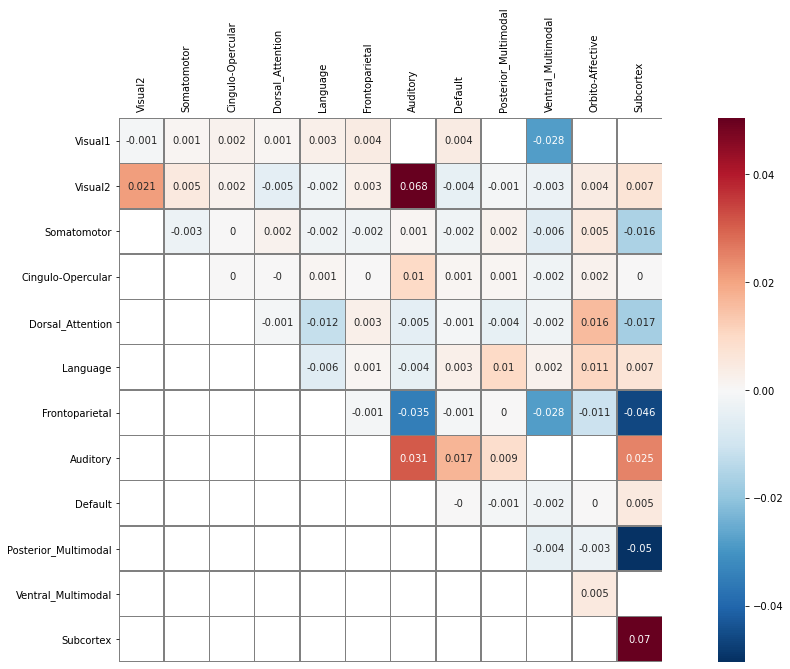

In [239]:
plt.figure(figsize=(20,10)) 
sns.heatmap(df_net.round(3), cmap='RdBu_r', vmin=(df_net.min().min()), vmax=(-(df_net.min().min())),
            cbar=True, annot=True, linewidths=.5, linecolor='gray', square=True) #cmap='RdBu_r', vmin=(df_net.min().min()), vmax=(-(df_net.min().min())),

plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.xticks(rotation='vertical')
plt.show()

In [240]:
net_color = ['blue',
'blueviolet',
'cyan',
'purple',
'lime',
'teal',
'yellow',
'orchid',
'red',
'sienna',
'sandybrown',
'olivedrab',
'silver']
node_colors = []
for i in np.arange(1,14,1):
    node_colors+=len(rest_matx_sort_up_mult.loc[(i, slice(None)), (i, slice(None))]) * [net_color[i-1]]

    
node_names = np.append(np.array([r[:-4] for r in rest_matx_sort.index[:-19]], dtype=str), rest_matx_sort.index[-19:])

In [241]:
pd.Series(node_colors).to_csv(wway+'vector_cole_node_colors.csv', header=False, index=False)

In [242]:
node_names = np.array([' ' for n in range(379)], dtype=str)

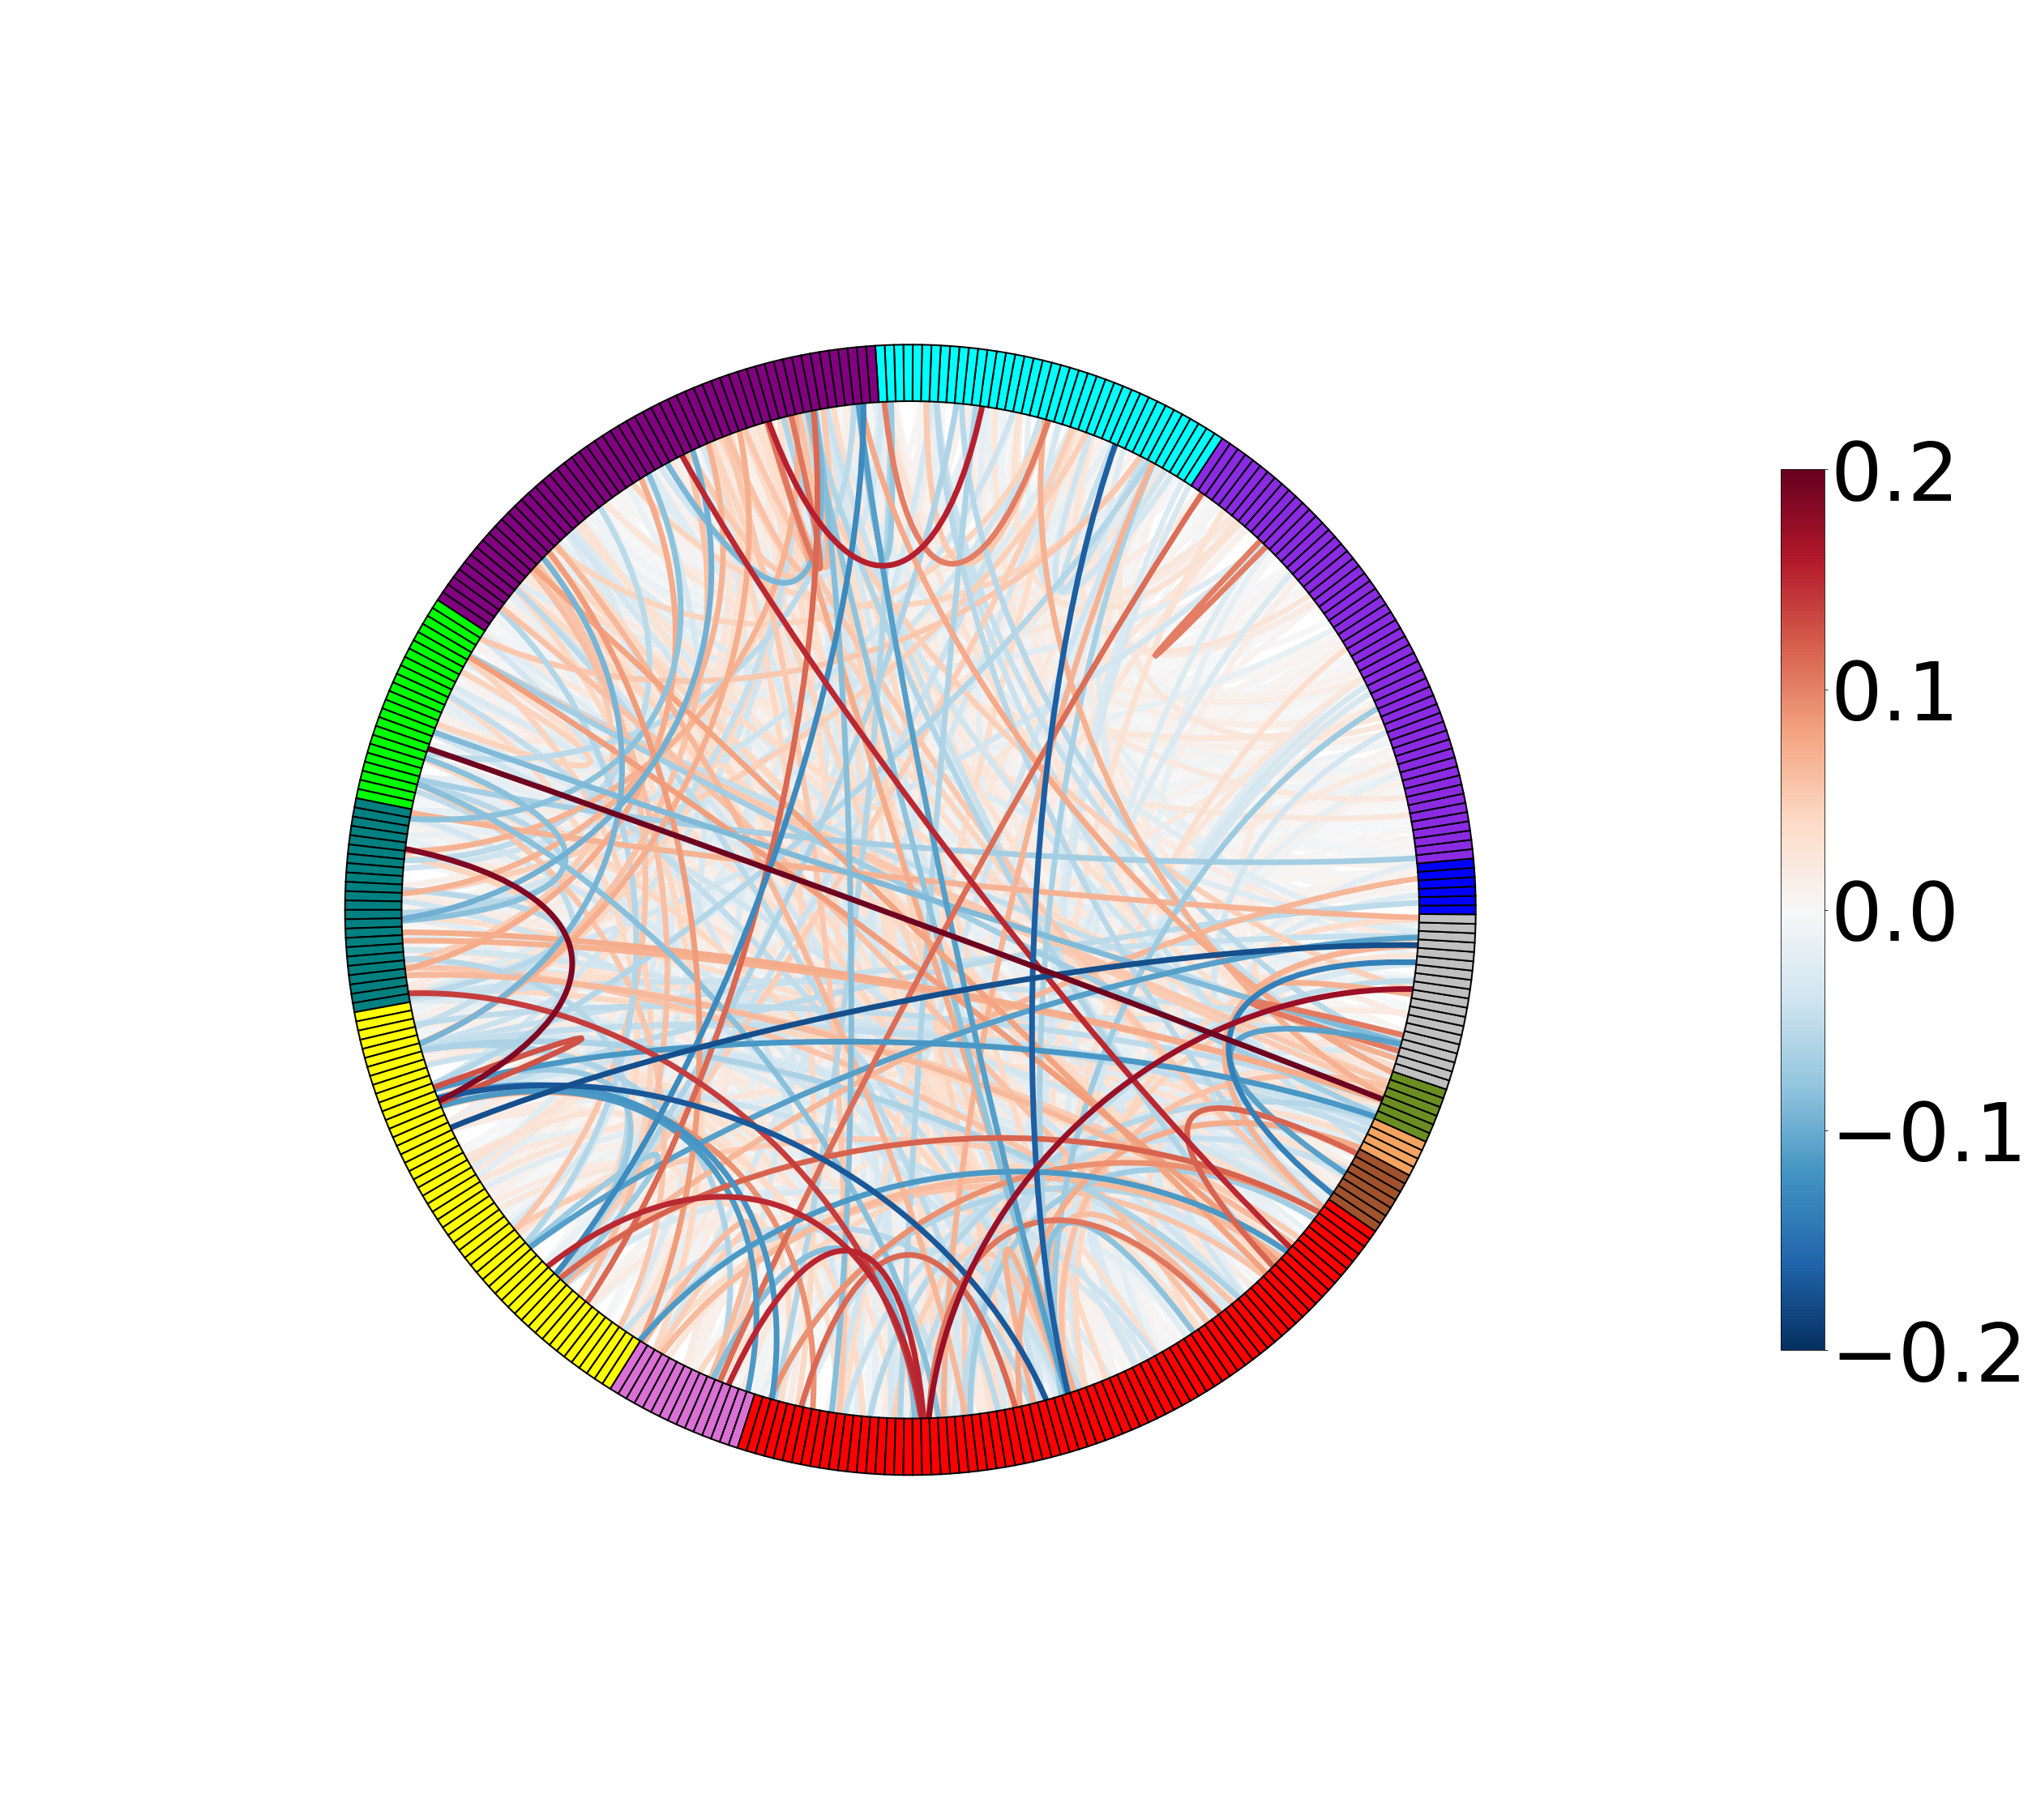

In [243]:
plot_connectivity_circle(np.array(rest_matx_sort, dtype=float), node_names,
                         colormap='RdBu_r', facecolor='white', textcolor='black', 
                         fig=plt.figure(figsize=(50,50)), 
                         node_colors=node_colors,
                         vmin=-0.2, vmax=0.2,
                         colorbar_size=0.4, colorbar_pos=(-0.5,0.5), fontsize_colorbar=100,
                         fontsize_names=14,
                         linewidth=7) 

plt.show() 

#### Additional

##### Mean tasks feature coeffs (based on Task stacked model coeffs and each single mod ML)

In [84]:
set2_coef.columns = list(dct_singleML_coeff.keys())[0:7]
dct_mean_tasks2={}
for key in set2_coef.columns:
    dct_mean_tasks2[key] = dct_singleML_coeff[key].mean() * set2_coef.mean()[key]
df_mean_tasks2 = pd.DataFrame(dct_mean_tasks2)
display(df_mean_tasks2.T.mean())

R_V1_ROI          0.126045
R_MST_ROI         0.001102
R_V6_ROI          0.027964
R_V2_ROI          0.040100
R_V3_ROI          0.013645
                    ...   
PALLIDUM_RIGHT   -0.050477
PUTAMEN_LEFT      0.031074
PUTAMEN_RIGHT     0.038873
THALAMUS_LEFT     0.036749
THALAMUS_RIGHT    0.146878
Length: 379, dtype: float64

In [85]:
#then calculate mean for each feature between folds and save it
df_mean_tasks2.T.mean().to_csv(path2+'mean_tasks2_set2_brain_elnet_coeffs.csv')
#save only cortex for next ploting in wb_view
df_mean_tasks2.T.mean()[0:360].to_csv(path2+'mean_tasks2_set2_cortex_gla_elnet_coeffs_nums.csv', header=None, index=None)

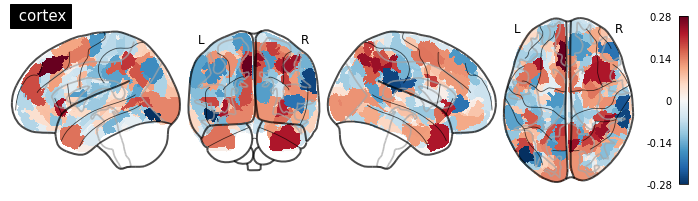

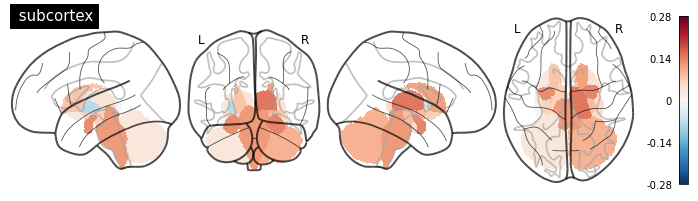

In [86]:
#plot mean feature coeff on glass_brain
wway = '/home/narunlab/Documents/HCP_analysis/atlases/'

atlas = nli.load_img(wway+'MMP_in_MNI_corr.nii.gz')
atlas2 = nli.load_img(wway+'subc2.fs.nii.gz')

par_dat = atlas.get_fdata()
par_dat2 = atlas2.get_fdata()

mrilist = lblY[:7]

#fig, axes = plt.subplots(nrows=14, ncols=1)

data = df_mean_tasks2.T.mean()

site_nii = np.zeros(par_dat.shape)
site_nii2 = np.zeros(par_dat2.shape)

vec = pd.Series(np.concatenate( [(data[180:360]).values, np.zeros(20), (data[0:180]).values]))
vec2 = pd.Series((data[360:]).values, index=pd.read_csv(wway+'atlas_index_num.csv')['nn'].values )


for index, numb in enumerate(vec): 
    site_nii[par_dat == (index+1)] = numb

for index, numb in zip(vec2.index, vec2.iloc[:]): 
    site_nii2[par_dat2 == (index)] = numb

site_img = nli.new_img_like(atlas, site_nii, atlas.affine, copy_header=True)

site_img2 = nli.new_img_like(atlas2, site_nii2, atlas2.affine, copy_header=True)

display1 =plotting.plot_glass_brain(site_img, plot_abs=False, cmap='RdBu_r', colorbar=True, display_mode='lyrz', 
                                    vmin=min(data), vmax=max(data), title=' cortex')
display2 = plotting.plot_glass_brain(site_img2, plot_abs=False, cmap='RdBu_r', colorbar=True, display_mode='lyrz', 
                                     vmin=min(data), vmax=max(data), title=' subcortex')

plotting.show()

In [87]:
# another version of mean task calculation  based on abs nums

#set2_coef.columns = list(dct_singleML_coeff.keys())[0:7]
dct_mean_tasks3={}
for key in set2_coef.columns:
    dct_mean_tasks3[key] = (dct_singleML_coeff[key].abs()).mean() * (set2_coef.abs()).mean()[key]
df_mean_tasks3 = pd.DataFrame(dct_mean_tasks3)
display(df_mean_tasks3.T.mean())

R_V1_ROI          0.126045
R_MST_ROI         0.093739
R_V6_ROI          0.091055
R_V2_ROI          0.064835
R_V3_ROI          0.050177
                    ...   
PALLIDUM_RIGHT    0.126385
PUTAMEN_LEFT      0.084425
PUTAMEN_RIGHT     0.077326
THALAMUS_LEFT     0.069552
THALAMUS_RIGHT    0.165154
Length: 379, dtype: float64

In [88]:
#then calculate mean for each feature between folds and save it
df_mean_tasks3.T.mean().to_csv(path2+'mean_tasksAbs_set2_brain_elnet_coeffs.csv')
#save only cortex for next ploting in wb_view
df_mean_tasks3.T.mean()[0:360].to_csv(path2+'mean_tasksAbs_set2_cortex_gla_elnet_coeffs_nums.csv', header=None, index=None)

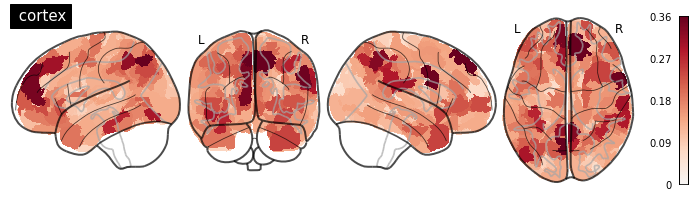

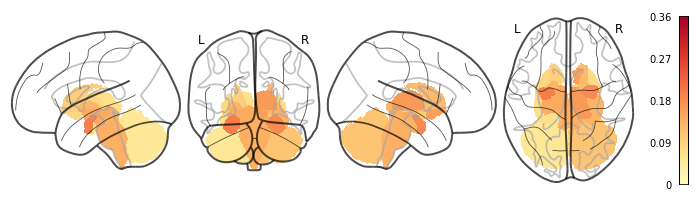

In [153]:
#plot mean feature coeff on glass_brain
wway = '/home/narunlab/Documents/HCP_analysis/atlases/'

atlas = nli.load_img(wway+'MMP_in_MNI_corr.nii.gz')
atlas2 = nli.load_img(wway+'subc2.fs.nii.gz')

par_dat = atlas.get_fdata()
par_dat2 = atlas2.get_fdata()

mrilist = lblY[:7]

#fig, axes = plt.subplots(nrows=14, ncols=1)

data = df_mean_tasks3.T.mean()

site_nii = np.zeros(par_dat.shape)
site_nii2 = np.zeros(par_dat2.shape)

vec = pd.Series(np.concatenate( [(data[180:360]).values, np.zeros(20), (data[0:180]).values]))
vec2 = pd.Series((data[360:]).values, index=pd.read_csv(wway+'atlas_index_num.csv')['nn'].values )


for index, numb in enumerate(vec): 
    site_nii[par_dat == (index+1)] = numb

for index, numb in zip(vec2.index, vec2.iloc[:]): 
    site_nii2[par_dat2 == (index)] = numb

site_img = nli.new_img_like(atlas, site_nii, atlas.affine, copy_header=True)

site_img2 = nli.new_img_like(atlas2, site_nii2, atlas2.affine, copy_header=True)

display1 =plotting.plot_glass_brain(site_img, plot_abs=False, cmap='RdBu_r', colorbar=True, display_mode='lyrz', 
                                    vmin=min(data), vmax=max(data), title=' cortex')
display2 = plotting.plot_glass_brain(site_img2, plot_abs=False, cmap='RdYlGn_r', colorbar=True, display_mode='lyrz', 
                                     vmin=min(data), vmax=max(data))

plotting.show()

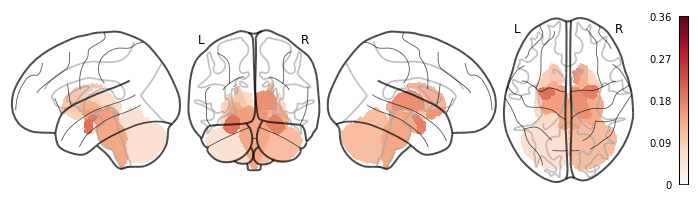

In [131]:
display2 = plotting.plot_glass_brain(site_img2, plot_abs=False, cmap='RdBu_r', colorbar=True, display_mode='lyrz', 
                                     vmin=min(data), vmax=max(data))

plotting.show()

In [90]:
#create cifti files for cortex brain image for glasses atlas

#read files with path
brain_files = list(glob.glob(path2+'*_cortex_gla_elnet_coeffs_nums.csv'))
#mod names
mod_brain_files = [b.split('/')[-1].split('_')[1] for b in brain_files]
#create cifti files with wb_commands
for i in range(len(brain_files)):
    cmd = 'wb_command -cifti-convert -from-text '+str(brain_files[i])+' '+wway+'glasser_cifti_empty_template.ptseries.nii' +' '+path2+'mean_'+str(mod_brain_files[i])+'_cortex_gla_elnet_coeffs.ptseries.nii'
    os.system(cmd)

##### Assemble 2level y-pred (used for training stacked model) into one table

In [166]:
#for the 2 level y-pred

#assamble y_pred from all folds into one table
#open dict for storing results
dt_ypred_all_2lvl = {}
#launch a loop for assembling
for fold in folders:
    #read saved tables
    df1 = pd.read_csv(path2+fold+'/2level_test1_y_pred_singleML.csv', index_col=0)
    df2 = pd.read_csv(path2+fold+'/2level_test1_y_pred_stacked.csv', index_col=0)
    yrl = pd.read_csv(path2+fold+'/2level_test1_y_real_residual_index.csv', index_col=0,header=None, squeeze=True)
    yrl.index.name = None
    #concat all in one for one fold
    df_y_rp = pd.concat([df1,df2], axis=1)
    df_y_rp['y_real'] = yrl
    df_y_rp['fold'] = np.full(len(yrl), fold[-1], dtype=int)
    #write to dict
    dt_ypred_all_2lvl[fold] = df_y_rp
    
#transform dict to one table
df_y_all_2lvl = dt_ypred_all_2lvl[folders[0]]
for fold in folders[1:]:
    df_y_all_2lvl = pd.concat([df_y_all_2lvl, dt_ypred_all_2lvl[fold]], axis=0)
#save
df_y_all_2lvl.to_csv(path2+'all_fold_y-pred_y-obs_2level.csv')